# Оптимизация сетей

Нейронные сети - это модели, которые могут быть потенциально произвольно сложными. Помимо того, что теперь для обучения таких моделей нам требуются гигантские датасеты, сами модели стали слишком большими. 

Это означает, что они занимают очень много места и например могут физически не помещаться на устройство пользователя. А также они очень медленно делают предсказания.

В этот раз поговорим про то, какие приемы могут помочь нам уменьшить размер модели и ускорить ее выполнение, стараясь при этом сохранить качество.

In [1]:
! wget -O- https://raw.githubusercontent.com/ADKosm/lsml-2021-public/main/data/mnist/mnist_784.csv.gz | gunzip > mnist_784.csv
! wget -O- https://raw.githubusercontent.com/ADKosm/lsml-2021-public/main/data/mnist/fashion-mnist_train.csv.gz | gunzip > fashion-mnist_train.csv
! wget -O- https://raw.githubusercontent.com/ADKosm/lsml-2021-public/main/data/mnist/fashion-mnist_test.csv.gz | gunzip > fashion-mnist_test.csv

--2022-03-13 21:49:41--  https://raw.githubusercontent.com/ADKosm/lsml-2021-public/main/data/mnist/mnist_784.csv.gz
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 14824659 (14M) [application/octet-stream]
Сохранение в: «STDOUT»

-                   100%[===================>]  14,14M   704KB/s    за 34s     

/2022-03-13 21:50:16 (432 KB/s) - записан в stdout [14824659/14824659]

--2022-03-13 21:50:17--  https://raw.githubusercontent.com/ADKosm/lsml-2021-public/main/data/mnist/fashion-mnist_train.csv.gz
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... соединение установлено.
HTTP-за

## Прореживание нейронных сетей

Попробуем уменьшить размер нейронной сети за счет удаления из нее части весов. 

In [5]:
! pip install torch==1.7.1

     |████████████████████████████████| 110.0 MB 144 kB/s            
  Using cached typing_extensions-4.1.1-py3-none-any.whl (26 kB)
You should consider upgrading via the '/Users/AlexHome/vms/lsml-internal/venv/bin/python -m pip install --upgrade pip' command.


In [6]:
! pip install torchvision==0.8.2

     |████████████████████████████████| 1.0 MB 665 kB/s            
  Using cached Pillow-9.0.1-cp39-cp39-macosx_10_10_x86_64.whl (3.0 MB)
You should consider upgrading via the '/Users/AlexHome/vms/lsml-internal/venv/bin/python -m pip install --upgrade pip' command.


In [7]:
! pip install matplotlib

     |████████████████████████████████| 7.3 MB 608 kB/s            
  Using cached kiwisolver-1.3.2-cp39-cp39-macosx_10_9_x86_64.whl (61 kB)
     |████████████████████████████████| 898 kB 164 kB/s            
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
You should consider upgrading via the '/Users/AlexHome/vms/lsml-internal/venv/bin/python -m pip install --upgrade pip' command.


In [10]:
! pip install sklearn

  Using cached sklearn-0.0-py2.py3-none-any.whl
  Using cached scikit_learn-1.0.2-cp39-cp39-macosx_10_13_x86_64.whl (8.0 MB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
     |████████████████████████████████| 55.6 MB 760 kB/s            
You should consider upgrading via the '/Users/AlexHome/vms/lsml-internal/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable

from sklearn.model_selection import train_test_split

In [3]:
SEED=9876
torch.manual_seed(SEED)

В качестве данных будем использовать стандартный mnist

In [4]:
df = pd.read_csv('mnist_784.csv')
df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [5]:
y = df['class'].values
X = df.drop(['class'],axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

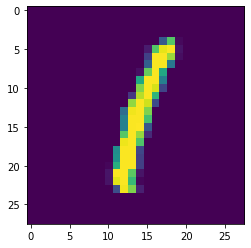

In [6]:
plt.imshow(X_train[0].reshape(28, 28))


Первое, что мы попробуем сделать - это собрать какую-то несложную архитектуру нейронной сети и просто обучить ее на данных. 

После этого мы замерим ее размер, а также качество, которое она выдает. Все дальнейшие полученные модели будем сравнивать с этими результатами, как с базовыми и понимать - получилось лучше или хуже.

Вначале просто подготовим данные для обучения.

In [7]:
BATCH_SIZE = 32

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)
torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)

train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

В реальной жизни для задачи распознавания числа на картинке мы бы скорее всего использовали более продвинутую архитектуру сети, однако для наглядности мы возьмем простую сеть, которая при этом имеет много параметров. В ней будут просто три полносвязных слоя: 784 - 250 - 100 - 10

In [8]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1)

mlp = MLP()
print(mlp)

MLP(
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)


Обучаем самым обычным способом, используя кросс-энтропию в качестве меры ошибки и используя 5 эпох

In [9]:
def fit(model, train_loader, epoch_number=5):
    optimizer = torch.optim.Adam(model.parameters())
    error = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(epoch_number):
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            if batch_idx % 50 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))

In [10]:
torch.manual_seed(SEED)
fit(mlp, train_loader)

Epoch : 0 [0/49000 (0%)]	Loss: 8.752557	 Accuracy:9.375%
Epoch : 0 [1600/49000 (3%)]	Loss: 0.328137	 Accuracy:69.179%
Epoch : 0 [3200/49000 (7%)]	Loss: 0.348055	 Accuracy:76.825%
Epoch : 0 [4800/49000 (10%)]	Loss: 0.260353	 Accuracy:79.988%
Epoch : 0 [6400/49000 (13%)]	Loss: 0.274885	 Accuracy:82.478%
Epoch : 0 [8000/49000 (16%)]	Loss: 0.284318	 Accuracy:83.877%
Epoch : 0 [9600/49000 (20%)]	Loss: 0.142767	 Accuracy:84.759%
Epoch : 0 [11200/49000 (23%)]	Loss: 0.533794	 Accuracy:85.684%
Epoch : 0 [12800/49000 (26%)]	Loss: 0.383269	 Accuracy:86.386%
Epoch : 0 [14400/49000 (29%)]	Loss: 0.217726	 Accuracy:86.973%
Epoch : 0 [16000/49000 (33%)]	Loss: 0.247426	 Accuracy:87.506%
Epoch : 0 [17600/49000 (36%)]	Loss: 0.295171	 Accuracy:87.903%
Epoch : 0 [19200/49000 (39%)]	Loss: 0.768353	 Accuracy:88.228%
Epoch : 0 [20800/49000 (42%)]	Loss: 0.029675	 Accuracy:88.609%
Epoch : 0 [22400/49000 (46%)]	Loss: 0.423048	 Accuracy:88.886%
Epoch : 0 [24000/49000 (49%)]	Loss: 0.439481	 Accuracy:89.160%
Epoch 

Epoch : 4 [12800/49000 (26%)]	Loss: 0.186442	 Accuracy:96.930%
Epoch : 4 [14400/49000 (29%)]	Loss: 0.031756	 Accuracy:96.889%
Epoch : 4 [16000/49000 (33%)]	Loss: 0.049820	 Accuracy:96.956%
Epoch : 4 [17600/49000 (36%)]	Loss: 0.069461	 Accuracy:96.943%
Epoch : 4 [19200/49000 (39%)]	Loss: 0.364155	 Accuracy:96.948%
Epoch : 4 [20800/49000 (42%)]	Loss: 0.004673	 Accuracy:96.918%
Epoch : 4 [22400/49000 (46%)]	Loss: 0.272254	 Accuracy:96.897%
Epoch : 4 [24000/49000 (49%)]	Loss: 0.197898	 Accuracy:96.896%
Epoch : 4 [25600/49000 (52%)]	Loss: 0.007085	 Accuracy:96.871%
Epoch : 4 [27200/49000 (55%)]	Loss: 0.201744	 Accuracy:96.915%
Epoch : 4 [28800/49000 (59%)]	Loss: 0.098582	 Accuracy:96.927%
Epoch : 4 [30400/49000 (62%)]	Loss: 0.009788	 Accuracy:96.918%
Epoch : 4 [32000/49000 (65%)]	Loss: 0.016327	 Accuracy:96.937%
Epoch : 4 [33600/49000 (69%)]	Loss: 0.130120	 Accuracy:96.967%
Epoch : 4 [35200/49000 (72%)]	Loss: 0.122135	 Accuracy:96.969%
Epoch : 4 [36800/49000 (75%)]	Loss: 0.119698	 Accuracy:

В качестве метрики качества возьмем обычный accuracy

In [12]:
def evaluate(model):
    correct = 0 
    for test_imgs, test_labels in test_loader:
        test_imgs = Variable(test_imgs).float()
        output = model(test_imgs)
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()
    print("Test accuracy:{:.3f}% ".format( float(correct) / (len(test_loader)*BATCH_SIZE)))

evaluate(mlp)

Test accuracy:0.960% 


Весьма неплохое качество, учитывая, что мы почти ничего не придумывали с сетью.

Посмотрим, сколько параметров нам потребовалось, чтобы получить это качество.

In [13]:
def calc_weights(model):
    result = 0
    for layer in model.children():
        result += len(layer.weight.reshape(-1))
    return result

In [14]:
calc_weights(mlp)

222000

Видно, что полносвязные слои достаточно тяжелые и всего три слоя дали нам больше чем 200 000 параметров. Попробуем ужать это число, не сильно уменьшим при этом качество.

### Удаляем связи внутри сети

Для того, чтобы начать оптимизировать размер сети, нам нужен инструментарий для удаления связей внутри нашей модели.

Нам потребуется особый полносвязный слой, в котором мы можем отключать конкретные веса. Используя такие слои, соберем такую же архитектруру с тремя полносвязными.

Отключать сами веса мы будем исходя из их абсолютного значения - задавая пороговое значение, мы будем занулять только те веса, которые меньше этого значения.

In [15]:
class MaskedLinear(nn.Module):
    def __init__(self, in_size, out_size):
        super(MaskedLinear, self).__init__()
        # Обычный полносвязный слой
        self._linear = nn.Linear(in_size, out_size) 
        # Маска для слоя. Для связи из оригинального слоя, здесь будут хранится 0 и 1. 
        # 1 - связь действует, 0 - связь не действует.
        self._mask = nn.Linear(in_size, out_size)
        # Изначально все числа в маске - 1. То есть изначально мы не выключаем вообще никакие веса
        self._mask.weight.data = torch.ones(self._mask.weight.size())
    
    def forward(self, x):
        # Чтобы применить этот слой, нужно вначале умножить веса на маску. 
        # Тогда те веса, которые мы выключили, занулятся, что и будет означать, что мы их просто выкинули
        self._linear.weight.data = torch.mul(self._linear.weight, self._mask.weight)
        return self._linear(x)
    
    def prune(self, threshold):
        # Для того, чтобы выключить часть связей задается threshold
        # Если значение веса по модулю в сети меньше, чем threshold, то мы его выключаем, а значит выставляем 0 в маске.
        self._mask.weight.data = torch.mul(torch.gt(torch.abs(self._linear.weight), threshold).float(), self._mask.weight)

Составляем точно такую же архитектуру, но используя наши особенные полносвязные слои, в которых мы можем отключать веса

In [16]:
class AutoCompressMLP(nn.Module):
    def __init__(self):
        super(AutoCompressMLP, self).__init__()
        self.linear1 = MaskedLinear(784,250)
        self.linear2 = MaskedLinear(250,100)
        self.linear3 = MaskedLinear(100,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1)
    
    def prune(self, threshold):
        self.linear1.prune(threshold)
        self.linear2.prune(threshold)
        self.linear3.prune(threshold)

Чтобы удалить какую-то долю связей из сети, необходимо вначале подсчитать необходимое пороговое значение. 

Так, чтобы удалить N% связей по этой схеме, необходимо найти такое число, чтобы ровно N% связей имело вес меньше этого числа по модулю. Другими словами найти N-перцентиль.

Напишем функцию, которая будет искать такое пороговое значение.

In [19]:
def calc_threshhold(model, rate):
    all_weights = torch.Tensor()
    for layer in model.children():
        all_weights = torch.cat( (layer._linear.weight.view(-1), all_weights.view(-1)) )
    abs_weight = torch.abs(all_weights)
    
    return np.percentile(abs_weight.detach().cpu().numpy(), rate)

In [20]:
acmlp = AutoCompressMLP()
t = calc_threshhold(acmlp, 50.0)
t

0.018787425011396408

Чтобы следить за тем, сколько параметров осталось внури нашей сети, нам потребуется немного другая функция подсчета активных весов, учитываящая маску.

In [21]:
def calc_pruned_weights(model):
    result = 0
    for layer in model.children():
        result += torch.sum(layer._mask.weight.reshape(-1))
    return int(result.item())

In [22]:
acmlp.prune(t)
calc_pruned_weights(acmlp)

111000

### Итеративное прореживание

Идин из способов сжатия нейронных сетей - итеративное прореживание (Incremental Magnitude Pruning). Он достаточно ресурсоемкий, однако позволяет достаточно несложными методами добиться неплохого результата.

In [23]:
acmlp = AutoCompressMLP()

Вначале просто обучим нашу модель, никаким образом ее не модифицируя.

In [24]:
torch.manual_seed(SEED)
fit(acmlp, train_loader)

Epoch : 0 [0/49000 (0%)]	Loss: 12.988437	 Accuracy:34.375%
Epoch : 0 [1600/49000 (3%)]	Loss: 0.285285	 Accuracy:67.770%
Epoch : 0 [3200/49000 (7%)]	Loss: 0.399245	 Accuracy:75.619%
Epoch : 0 [4800/49000 (10%)]	Loss: 0.295355	 Accuracy:79.863%
Epoch : 0 [6400/49000 (13%)]	Loss: 0.627711	 Accuracy:82.090%
Epoch : 0 [8000/49000 (16%)]	Loss: 0.715258	 Accuracy:83.528%
Epoch : 0 [9600/49000 (20%)]	Loss: 0.129665	 Accuracy:84.437%
Epoch : 0 [11200/49000 (23%)]	Loss: 0.482205	 Accuracy:85.239%
Epoch : 0 [12800/49000 (26%)]	Loss: 0.412768	 Accuracy:85.817%
Epoch : 0 [14400/49000 (29%)]	Loss: 0.358222	 Accuracy:86.481%
Epoch : 0 [16000/49000 (33%)]	Loss: 0.488665	 Accuracy:87.070%
Epoch : 0 [17600/49000 (36%)]	Loss: 0.053358	 Accuracy:87.523%
Epoch : 0 [19200/49000 (39%)]	Loss: 0.866225	 Accuracy:87.895%
Epoch : 0 [20800/49000 (42%)]	Loss: 0.036892	 Accuracy:88.268%
Epoch : 0 [22400/49000 (46%)]	Loss: 0.306077	 Accuracy:88.534%
Epoch : 0 [24000/49000 (49%)]	Loss: 0.166066	 Accuracy:88.777%
Epoc

Epoch : 4 [14400/49000 (29%)]	Loss: 0.133909	 Accuracy:96.570%
Epoch : 4 [16000/49000 (33%)]	Loss: 0.195847	 Accuracy:96.632%
Epoch : 4 [17600/49000 (36%)]	Loss: 0.082457	 Accuracy:96.659%
Epoch : 4 [19200/49000 (39%)]	Loss: 0.340325	 Accuracy:96.641%
Epoch : 4 [20800/49000 (42%)]	Loss: 0.009543	 Accuracy:96.659%
Epoch : 4 [22400/49000 (46%)]	Loss: 0.129090	 Accuracy:96.608%
Epoch : 4 [24000/49000 (49%)]	Loss: 0.112892	 Accuracy:96.563%
Epoch : 4 [25600/49000 (52%)]	Loss: 0.026490	 Accuracy:96.578%
Epoch : 4 [27200/49000 (55%)]	Loss: 0.279369	 Accuracy:96.600%
Epoch : 4 [28800/49000 (59%)]	Loss: 0.059310	 Accuracy:96.622%
Epoch : 4 [30400/49000 (62%)]	Loss: 0.095430	 Accuracy:96.586%
Epoch : 4 [32000/49000 (65%)]	Loss: 0.007253	 Accuracy:96.631%
Epoch : 4 [33600/49000 (69%)]	Loss: 0.044925	 Accuracy:96.667%
Epoch : 4 [35200/49000 (72%)]	Loss: 0.052482	 Accuracy:96.651%
Epoch : 4 [36800/49000 (75%)]	Loss: 0.008377	 Accuracy:96.690%
Epoch : 4 [38400/49000 (78%)]	Loss: 0.057706	 Accuracy:

In [25]:
evaluate(acmlp)

Test accuracy:0.955% 


Отлично, получили примерно такую же модель, как и в самом начале. 

Сейчас модель уже имеет хорошие веса для предсказаний. Теперь попробуем убрать из нее 50% связей и посмотрим, насколько ей удастся сохранить качество.

Как уже отмечалось, отключим 50% наиболее слабых связей в сети.

In [26]:
import copy

acmlp_test1 = copy.deepcopy(acmlp)

In [27]:
t_50 = calc_threshhold(acmlp_test1, 50.0)
acmlp_test1.prune(t_50)

In [28]:
evaluate(acmlp_test1)

Test accuracy:0.943% 


Можно заметить, что таким образом выкинутые веса почти не повлияли на качество сети. При этом мы выкинули половину всех коэффициентов! Весьма неплохой результат.

Давайте посмотрим, можем ли мы с таким же успехом выкинуть 90% сети?

In [29]:
acmlp_test2 = copy.deepcopy(acmlp)

t_90 = calc_threshhold(acmlp_test2, 90.0)
acmlp_test2.prune(t_90)

In [30]:
evaluate(acmlp_test2)

Test accuracy:0.296% 


Увы, так просто выкинуть 90% и оставить качество не получается. Будем использовать более хитрый подход.

Будет идти с шагом в 10%. Каждый раз будет отключать внутри сети 10% связей. После отключения, оставшиеся веса дообучим на всех данных используя всего одну эпоху. Ожидается, что так как мы выкинули за один раз не очень много, то оставшиеся связи "перехватят" ответственность тех слабых, которые мы только что отключили.

Таким образом за P таких итераций мы выкинем 10P% всей сети и не должны при этом потерять сильно в качестве.

In [31]:
def smart_prune(model, train_loader, compress_rate):
    # Создаем именно новую модель, старую не трогаем
    model = copy.deepcopy(model)
    optimizer = torch.optim.Adam(model.parameters())
    error = nn.CrossEntropyLoss()
    model.train()
    
    for rate in range(0, compress_rate+1, 10):  # Идем с шагом в 10%
        t = calc_threshhold(model, float(rate))  # Считаем очередное пороговое значение
        model.prune(t)  # Отключаем слабые связи
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):  # Далее дообучаем модель как обычно в течение одной эпохи
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            if batch_idx % 20 == 0:
                print('Rate : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    rate, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))
    return model

Попробуем для начала выкинуть 70% таким образом

In [32]:
torch.manual_seed(SEED)
pruned_model = smart_prune(acmlp, train_loader, 70)

Rate : 0 [0/49000 (0%)]	Loss: 0.031662	 Accuracy:100.000%
Rate : 0 [640/49000 (1%)]	Loss: 0.131079	 Accuracy:96.726%
Rate : 0 [1280/49000 (3%)]	Loss: 0.260266	 Accuracy:96.494%
Rate : 0 [1920/49000 (4%)]	Loss: 0.021289	 Accuracy:96.516%
Rate : 0 [2560/49000 (5%)]	Loss: 0.220054	 Accuracy:96.489%
Rate : 0 [3200/49000 (7%)]	Loss: 0.141963	 Accuracy:96.844%
Rate : 0 [3840/49000 (8%)]	Loss: 0.002043	 Accuracy:96.823%
Rate : 0 [4480/49000 (9%)]	Loss: 0.401672	 Accuracy:96.764%
Rate : 0 [5120/49000 (10%)]	Loss: 0.790331	 Accuracy:96.894%
Rate : 0 [5760/49000 (12%)]	Loss: 0.257273	 Accuracy:97.065%
Rate : 0 [6400/49000 (13%)]	Loss: 0.094841	 Accuracy:96.999%
Rate : 0 [7040/49000 (14%)]	Loss: 0.193954	 Accuracy:97.002%
Rate : 0 [7680/49000 (16%)]	Loss: 0.311790	 Accuracy:96.940%
Rate : 0 [8320/49000 (17%)]	Loss: 0.260763	 Accuracy:96.887%
Rate : 0 [8960/49000 (18%)]	Loss: 0.022661	 Accuracy:96.875%
Rate : 0 [9600/49000 (20%)]	Loss: 0.021327	 Accuracy:96.865%
Rate : 0 [10240/49000 (21%)]	Loss: 

Rate : 10 [37120/49000 (76%)]	Loss: 0.004724	 Accuracy:97.648%
Rate : 10 [37760/49000 (77%)]	Loss: 0.010148	 Accuracy:97.664%
Rate : 10 [38400/49000 (78%)]	Loss: 0.180426	 Accuracy:97.674%
Rate : 10 [39040/49000 (80%)]	Loss: 0.026186	 Accuracy:97.676%
Rate : 10 [39680/49000 (81%)]	Loss: 0.006909	 Accuracy:97.681%
Rate : 10 [40320/49000 (82%)]	Loss: 0.015055	 Accuracy:97.703%
Rate : 10 [40960/49000 (84%)]	Loss: 0.019710	 Accuracy:97.704%
Rate : 10 [41600/49000 (85%)]	Loss: 0.130606	 Accuracy:97.713%
Rate : 10 [42240/49000 (86%)]	Loss: 0.029194	 Accuracy:97.708%
Rate : 10 [42880/49000 (87%)]	Loss: 0.044540	 Accuracy:97.695%
Rate : 10 [43520/49000 (89%)]	Loss: 0.014154	 Accuracy:97.699%
Rate : 10 [44160/49000 (90%)]	Loss: 0.025861	 Accuracy:97.694%
Rate : 10 [44800/49000 (91%)]	Loss: 0.049685	 Accuracy:97.689%
Rate : 10 [45440/49000 (93%)]	Loss: 0.088772	 Accuracy:97.689%
Rate : 10 [46080/49000 (94%)]	Loss: 0.094827	 Accuracy:97.688%
Rate : 10 [46720/49000 (95%)]	Loss: 0.048499	 Accuracy:

Rate : 30 [24320/49000 (50%)]	Loss: 0.027562	 Accuracy:98.160%
Rate : 30 [24960/49000 (51%)]	Loss: 0.015172	 Accuracy:98.155%
Rate : 30 [25600/49000 (52%)]	Loss: 0.005900	 Accuracy:98.139%
Rate : 30 [26240/49000 (54%)]	Loss: 0.006174	 Accuracy:98.116%
Rate : 30 [26880/49000 (55%)]	Loss: 0.013263	 Accuracy:98.127%
Rate : 30 [27520/49000 (56%)]	Loss: 0.000700	 Accuracy:98.131%
Rate : 30 [28160/49000 (57%)]	Loss: 0.193057	 Accuracy:98.145%
Rate : 30 [28800/49000 (59%)]	Loss: 0.026822	 Accuracy:98.165%
Rate : 30 [29440/49000 (60%)]	Loss: 0.052132	 Accuracy:98.168%
Rate : 30 [30080/49000 (61%)]	Loss: 0.064794	 Accuracy:98.164%
Rate : 30 [30720/49000 (63%)]	Loss: 0.000068	 Accuracy:98.163%
Rate : 30 [31360/49000 (64%)]	Loss: 0.373646	 Accuracy:98.175%
Rate : 30 [32000/49000 (65%)]	Loss: 0.001499	 Accuracy:98.192%
Rate : 30 [32640/49000 (67%)]	Loss: 0.007683	 Accuracy:98.182%
Rate : 30 [33280/49000 (68%)]	Loss: 0.004379	 Accuracy:98.175%
Rate : 30 [33920/49000 (69%)]	Loss: 0.018445	 Accuracy:

Rate : 50 [10880/49000 (22%)]	Loss: 0.046897	 Accuracy:98.405%
Rate : 50 [11520/49000 (23%)]	Loss: 0.002434	 Accuracy:98.373%
Rate : 50 [12160/49000 (25%)]	Loss: 0.049466	 Accuracy:98.368%
Rate : 50 [12800/49000 (26%)]	Loss: 0.076695	 Accuracy:98.356%
Rate : 50 [13440/49000 (27%)]	Loss: 0.001654	 Accuracy:98.360%
Rate : 50 [14080/49000 (29%)]	Loss: 0.041311	 Accuracy:98.342%
Rate : 50 [14720/49000 (30%)]	Loss: 0.038717	 Accuracy:98.366%
Rate : 50 [15360/49000 (31%)]	Loss: 0.003659	 Accuracy:98.389%
Rate : 50 [16000/49000 (33%)]	Loss: 0.005589	 Accuracy:98.378%
Rate : 50 [16640/49000 (34%)]	Loss: 0.047885	 Accuracy:98.399%
Rate : 50 [17280/49000 (35%)]	Loss: 0.004129	 Accuracy:98.423%
Rate : 50 [17920/49000 (37%)]	Loss: 0.008827	 Accuracy:98.407%
Rate : 50 [18560/49000 (38%)]	Loss: 0.012986	 Accuracy:98.424%
Rate : 50 [19200/49000 (39%)]	Loss: 0.285066	 Accuracy:98.414%
Rate : 50 [19840/49000 (40%)]	Loss: 0.035836	 Accuracy:98.390%
Rate : 50 [20480/49000 (42%)]	Loss: 0.026060	 Accuracy:

Rate : 60 [46080/49000 (94%)]	Loss: 0.000977	 Accuracy:98.801%
Rate : 60 [46720/49000 (95%)]	Loss: 0.001470	 Accuracy:98.811%
Rate : 60 [47360/49000 (97%)]	Loss: 0.001485	 Accuracy:98.816%
Rate : 60 [48000/49000 (98%)]	Loss: 0.253610	 Accuracy:98.811%
Rate : 60 [48640/49000 (99%)]	Loss: 0.020339	 Accuracy:98.812%
Rate : 70 [0/49000 (0%)]	Loss: 0.026265	 Accuracy:100.000%
Rate : 70 [640/49000 (1%)]	Loss: 0.030428	 Accuracy:97.024%
Rate : 70 [1280/49000 (3%)]	Loss: 0.436806	 Accuracy:97.637%
Rate : 70 [1920/49000 (4%)]	Loss: 0.000358	 Accuracy:97.695%
Rate : 70 [2560/49000 (5%)]	Loss: 0.004122	 Accuracy:97.955%
Rate : 70 [3200/49000 (7%)]	Loss: 0.023337	 Accuracy:98.113%
Rate : 70 [3840/49000 (8%)]	Loss: 0.002239	 Accuracy:98.037%
Rate : 70 [4480/49000 (9%)]	Loss: 0.001476	 Accuracy:97.961%
Rate : 70 [5120/49000 (10%)]	Loss: 0.017487	 Accuracy:97.962%
Rate : 70 [5760/49000 (12%)]	Loss: 0.015835	 Accuracy:98.049%
Rate : 70 [6400/49000 (13%)]	Loss: 0.027883	 Accuracy:98.119%
Rate : 70 [704

In [33]:
evaluate(pruned_model)

Test accuracy:0.973% 


На моем компьютере получилось качество около 0.97. Формально это даже чуточку лучше, чем оригинальная модель! Получается, что лишние веса в оригинальной модели могли мешали выявить зависимость в данных. 

Давайте посчитаем количество ненулевых весов в модели

In [34]:
calc_pruned_weights(acmlp)

222000

In [35]:
calc_pruned_weights(pruned_model)

66600

Оставили около 60 000 весов, мы получили почти такое же качество для модели!

Можем ли мы таким же образом выкинуть 90%?

In [36]:
torch.manual_seed(SEED)
pruned_model_90 = smart_prune(acmlp, train_loader, 90)

Rate : 0 [0/49000 (0%)]	Loss: 0.031662	 Accuracy:100.000%
Rate : 0 [640/49000 (1%)]	Loss: 0.131079	 Accuracy:96.726%
Rate : 0 [1280/49000 (3%)]	Loss: 0.260266	 Accuracy:96.494%
Rate : 0 [1920/49000 (4%)]	Loss: 0.021289	 Accuracy:96.516%
Rate : 0 [2560/49000 (5%)]	Loss: 0.220054	 Accuracy:96.489%
Rate : 0 [3200/49000 (7%)]	Loss: 0.141963	 Accuracy:96.844%
Rate : 0 [3840/49000 (8%)]	Loss: 0.002043	 Accuracy:96.823%
Rate : 0 [4480/49000 (9%)]	Loss: 0.401672	 Accuracy:96.764%
Rate : 0 [5120/49000 (10%)]	Loss: 0.790331	 Accuracy:96.894%
Rate : 0 [5760/49000 (12%)]	Loss: 0.257273	 Accuracy:97.065%
Rate : 0 [6400/49000 (13%)]	Loss: 0.094841	 Accuracy:96.999%
Rate : 0 [7040/49000 (14%)]	Loss: 0.193954	 Accuracy:97.002%
Rate : 0 [7680/49000 (16%)]	Loss: 0.311790	 Accuracy:96.940%
Rate : 0 [8320/49000 (17%)]	Loss: 0.260763	 Accuracy:96.887%
Rate : 0 [8960/49000 (18%)]	Loss: 0.022661	 Accuracy:96.875%
Rate : 0 [9600/49000 (20%)]	Loss: 0.021327	 Accuracy:96.865%
Rate : 0 [10240/49000 (21%)]	Loss: 

Rate : 10 [37120/49000 (76%)]	Loss: 0.004724	 Accuracy:97.648%
Rate : 10 [37760/49000 (77%)]	Loss: 0.010148	 Accuracy:97.664%
Rate : 10 [38400/49000 (78%)]	Loss: 0.180426	 Accuracy:97.674%
Rate : 10 [39040/49000 (80%)]	Loss: 0.026186	 Accuracy:97.676%
Rate : 10 [39680/49000 (81%)]	Loss: 0.006909	 Accuracy:97.681%
Rate : 10 [40320/49000 (82%)]	Loss: 0.015055	 Accuracy:97.703%
Rate : 10 [40960/49000 (84%)]	Loss: 0.019710	 Accuracy:97.704%
Rate : 10 [41600/49000 (85%)]	Loss: 0.130606	 Accuracy:97.713%
Rate : 10 [42240/49000 (86%)]	Loss: 0.029194	 Accuracy:97.708%
Rate : 10 [42880/49000 (87%)]	Loss: 0.044540	 Accuracy:97.695%
Rate : 10 [43520/49000 (89%)]	Loss: 0.014154	 Accuracy:97.699%
Rate : 10 [44160/49000 (90%)]	Loss: 0.025861	 Accuracy:97.694%
Rate : 10 [44800/49000 (91%)]	Loss: 0.049685	 Accuracy:97.689%
Rate : 10 [45440/49000 (93%)]	Loss: 0.088772	 Accuracy:97.689%
Rate : 10 [46080/49000 (94%)]	Loss: 0.094827	 Accuracy:97.688%
Rate : 10 [46720/49000 (95%)]	Loss: 0.048499	 Accuracy:

Rate : 30 [24320/49000 (50%)]	Loss: 0.027562	 Accuracy:98.160%
Rate : 30 [24960/49000 (51%)]	Loss: 0.015172	 Accuracy:98.155%
Rate : 30 [25600/49000 (52%)]	Loss: 0.005900	 Accuracy:98.139%
Rate : 30 [26240/49000 (54%)]	Loss: 0.006174	 Accuracy:98.116%
Rate : 30 [26880/49000 (55%)]	Loss: 0.013263	 Accuracy:98.127%
Rate : 30 [27520/49000 (56%)]	Loss: 0.000700	 Accuracy:98.131%
Rate : 30 [28160/49000 (57%)]	Loss: 0.193057	 Accuracy:98.145%
Rate : 30 [28800/49000 (59%)]	Loss: 0.026822	 Accuracy:98.165%
Rate : 30 [29440/49000 (60%)]	Loss: 0.052132	 Accuracy:98.168%
Rate : 30 [30080/49000 (61%)]	Loss: 0.064794	 Accuracy:98.164%
Rate : 30 [30720/49000 (63%)]	Loss: 0.000068	 Accuracy:98.163%
Rate : 30 [31360/49000 (64%)]	Loss: 0.373646	 Accuracy:98.175%
Rate : 30 [32000/49000 (65%)]	Loss: 0.001499	 Accuracy:98.192%
Rate : 30 [32640/49000 (67%)]	Loss: 0.007683	 Accuracy:98.182%
Rate : 30 [33280/49000 (68%)]	Loss: 0.004379	 Accuracy:98.175%
Rate : 30 [33920/49000 (69%)]	Loss: 0.018445	 Accuracy:

Rate : 50 [9600/49000 (20%)]	Loss: 0.000595	 Accuracy:98.422%
Rate : 50 [10240/49000 (21%)]	Loss: 0.211112	 Accuracy:98.403%
Rate : 50 [10880/49000 (22%)]	Loss: 0.046897	 Accuracy:98.405%
Rate : 50 [11520/49000 (23%)]	Loss: 0.002434	 Accuracy:98.373%
Rate : 50 [12160/49000 (25%)]	Loss: 0.049466	 Accuracy:98.368%
Rate : 50 [12800/49000 (26%)]	Loss: 0.076695	 Accuracy:98.356%
Rate : 50 [13440/49000 (27%)]	Loss: 0.001654	 Accuracy:98.360%
Rate : 50 [14080/49000 (29%)]	Loss: 0.041311	 Accuracy:98.342%
Rate : 50 [14720/49000 (30%)]	Loss: 0.038717	 Accuracy:98.366%
Rate : 50 [15360/49000 (31%)]	Loss: 0.003659	 Accuracy:98.389%
Rate : 50 [16000/49000 (33%)]	Loss: 0.005589	 Accuracy:98.378%
Rate : 50 [16640/49000 (34%)]	Loss: 0.047885	 Accuracy:98.399%
Rate : 50 [17280/49000 (35%)]	Loss: 0.004129	 Accuracy:98.423%
Rate : 50 [17920/49000 (37%)]	Loss: 0.008827	 Accuracy:98.407%
Rate : 50 [18560/49000 (38%)]	Loss: 0.012986	 Accuracy:98.424%
Rate : 50 [19200/49000 (39%)]	Loss: 0.285066	 Accuracy:9

Rate : 60 [44160/49000 (90%)]	Loss: 0.001052	 Accuracy:98.794%
Rate : 60 [44800/49000 (91%)]	Loss: 0.004039	 Accuracy:98.791%
Rate : 60 [45440/49000 (93%)]	Loss: 0.001009	 Accuracy:98.795%
Rate : 60 [46080/49000 (94%)]	Loss: 0.000977	 Accuracy:98.801%
Rate : 60 [46720/49000 (95%)]	Loss: 0.001470	 Accuracy:98.811%
Rate : 60 [47360/49000 (97%)]	Loss: 0.001485	 Accuracy:98.816%
Rate : 60 [48000/49000 (98%)]	Loss: 0.253610	 Accuracy:98.811%
Rate : 60 [48640/49000 (99%)]	Loss: 0.020339	 Accuracy:98.812%
Rate : 70 [0/49000 (0%)]	Loss: 0.026265	 Accuracy:100.000%
Rate : 70 [640/49000 (1%)]	Loss: 0.030428	 Accuracy:97.024%
Rate : 70 [1280/49000 (3%)]	Loss: 0.436806	 Accuracy:97.637%
Rate : 70 [1920/49000 (4%)]	Loss: 0.000358	 Accuracy:97.695%
Rate : 70 [2560/49000 (5%)]	Loss: 0.004122	 Accuracy:97.955%
Rate : 70 [3200/49000 (7%)]	Loss: 0.023337	 Accuracy:98.113%
Rate : 70 [3840/49000 (8%)]	Loss: 0.002239	 Accuracy:98.037%
Rate : 70 [4480/49000 (9%)]	Loss: 0.001476	 Accuracy:97.961%
Rate : 70 [

Rate : 80 [29440/49000 (60%)]	Loss: 0.195398	 Accuracy:87.300%
Rate : 80 [30080/49000 (61%)]	Loss: 0.286479	 Accuracy:87.427%
Rate : 80 [30720/49000 (63%)]	Loss: 0.044704	 Accuracy:87.581%
Rate : 80 [31360/49000 (64%)]	Loss: 0.804738	 Accuracy:87.761%
Rate : 80 [32000/49000 (65%)]	Loss: 0.123163	 Accuracy:87.931%
Rate : 80 [32640/49000 (67%)]	Loss: 0.280447	 Accuracy:88.075%
Rate : 80 [33280/49000 (68%)]	Loss: 0.061631	 Accuracy:88.223%
Rate : 80 [33920/49000 (69%)]	Loss: 0.019231	 Accuracy:88.328%
Rate : 80 [34560/49000 (70%)]	Loss: 0.125393	 Accuracy:88.471%
Rate : 80 [35200/49000 (72%)]	Loss: 0.063853	 Accuracy:88.590%
Rate : 80 [35840/49000 (73%)]	Loss: 0.036134	 Accuracy:88.741%
Rate : 80 [36480/49000 (74%)]	Loss: 0.046233	 Accuracy:88.867%
Rate : 80 [37120/49000 (76%)]	Loss: 0.361173	 Accuracy:88.999%
Rate : 80 [37760/49000 (77%)]	Loss: 0.187592	 Accuracy:89.109%
Rate : 80 [38400/49000 (78%)]	Loss: 0.239773	 Accuracy:89.223%
Rate : 80 [39040/49000 (80%)]	Loss: 0.114466	 Accuracy:

In [39]:
evaluate(pruned_model_90)

Test accuracy:0.921% 


In [40]:
calc_pruned_weights(pruned_model_90)

22200

Выкинув большую часть сети, мы все еще имеем относительно неплохое качество, хоть и меньше, чем изначально. 

Вполне возможно проблема в том, что мы слишком агрессивно удаляем связи, когда их остается совсем мало. Давайте попробуем более аккуратные шаги.


In [41]:
def smart_prune_shed(model, train_loader, schedule):
    # Создаем именно новую модель, старую не трогаем
    model = copy.deepcopy(model)
    optimizer = torch.optim.Adam(model.parameters())
    error = nn.CrossEntropyLoss()
    model.train()
    
    for rate, epochs in schedule:  # Идем шагами, согласно тому расписанию, которое передали в функцию
        t = calc_threshhold(model, float(rate))  # Считаем очередное пороговое значение
        model.prune(t)  # Отключаем слабые связи
        for i in range(epochs):
            correct = 0
            for batch_idx, (X_batch, y_batch) in enumerate(train_loader):  # Далее дообучаем модель как обычно в течение указанного количества эпох
                var_X_batch = Variable(X_batch).float()
                var_y_batch = Variable(y_batch)
                optimizer.zero_grad()
                output = model(var_X_batch)
                loss = error(output, var_y_batch)
                loss.backward()
                optimizer.step()

                predicted = torch.max(output.data, 1)[1] 
                correct += (predicted == var_y_batch).sum()
                if batch_idx % 20 == 0:
                    print('Rate : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                        rate, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))
    return model

In [40]:
torch.manual_seed(SEED)
pruned_model_90 = smart_prune_shed(acmlp, train_loader, [
    (0, 1), 
    (40, 1), 
    (50, 1), 
    (60, 1), 
    (70, 1), 
    (80, 2), 
    (83, 2), 
    (85, 2), 
    (87, 2), 
    (89, 2), 
    (90, 2)
])

Rate : 0 [0/49000 (0%)]	Loss: 0.005384	 Accuracy:100.000%
Rate : 0 [640/49000 (1%)]	Loss: 0.000911	 Accuracy:98.065%
Rate : 0 [1280/49000 (3%)]	Loss: 0.202851	 Accuracy:97.485%
Rate : 0 [1920/49000 (4%)]	Loss: 0.000099	 Accuracy:97.387%
Rate : 0 [2560/49000 (5%)]	Loss: 0.094035	 Accuracy:97.106%
Rate : 0 [3200/49000 (7%)]	Loss: 0.001190	 Accuracy:97.308%
Rate : 0 [3840/49000 (8%)]	Loss: 0.108540	 Accuracy:97.521%
Rate : 0 [4480/49000 (9%)]	Loss: 0.001416	 Accuracy:97.429%
Rate : 0 [5120/49000 (10%)]	Loss: 0.439223	 Accuracy:97.380%
Rate : 0 [5760/49000 (12%)]	Loss: 0.401924	 Accuracy:97.341%
Rate : 0 [6400/49000 (13%)]	Loss: 0.012014	 Accuracy:97.373%
Rate : 0 [7040/49000 (14%)]	Loss: 0.074397	 Accuracy:97.243%
Rate : 0 [7680/49000 (16%)]	Loss: 0.016140	 Accuracy:97.264%
Rate : 0 [8320/49000 (17%)]	Loss: 0.229941	 Accuracy:97.246%
Rate : 0 [8960/49000 (18%)]	Loss: 0.735903	 Accuracy:97.198%
Rate : 0 [9600/49000 (20%)]	Loss: 0.063619	 Accuracy:97.124%
Rate : 0 [10240/49000 (21%)]	Loss: 

Rate : 40 [36480/49000 (74%)]	Loss: 0.004357	 Accuracy:97.771%
Rate : 40 [37120/49000 (76%)]	Loss: 0.001037	 Accuracy:97.787%
Rate : 40 [37760/49000 (77%)]	Loss: 0.034745	 Accuracy:97.806%
Rate : 40 [38400/49000 (78%)]	Loss: 0.030201	 Accuracy:97.814%
Rate : 40 [39040/49000 (80%)]	Loss: 0.054389	 Accuracy:97.801%
Rate : 40 [39680/49000 (81%)]	Loss: 0.028741	 Accuracy:97.804%
Rate : 40 [40320/49000 (82%)]	Loss: 0.000039	 Accuracy:97.817%
Rate : 40 [40960/49000 (84%)]	Loss: 0.003018	 Accuracy:97.824%
Rate : 40 [41600/49000 (85%)]	Loss: 0.000240	 Accuracy:97.836%
Rate : 40 [42240/49000 (86%)]	Loss: 0.000264	 Accuracy:97.845%
Rate : 40 [42880/49000 (87%)]	Loss: 0.270638	 Accuracy:97.847%
Rate : 40 [43520/49000 (89%)]	Loss: 0.178158	 Accuracy:97.853%
Rate : 40 [44160/49000 (90%)]	Loss: 0.007313	 Accuracy:97.859%
Rate : 40 [44800/49000 (91%)]	Loss: 0.064545	 Accuracy:97.863%
Rate : 40 [45440/49000 (93%)]	Loss: 0.035238	 Accuracy:97.867%
Rate : 40 [46080/49000 (94%)]	Loss: 0.001478	 Accuracy:

Rate : 60 [21760/49000 (44%)]	Loss: 0.073671	 Accuracy:98.587%
Rate : 60 [22400/49000 (46%)]	Loss: 0.081292	 Accuracy:98.587%
Rate : 60 [23040/49000 (47%)]	Loss: 0.091297	 Accuracy:98.574%
Rate : 60 [23680/49000 (48%)]	Loss: 0.059180	 Accuracy:98.570%
Rate : 60 [24320/49000 (50%)]	Loss: 0.047158	 Accuracy:98.591%
Rate : 60 [24960/49000 (51%)]	Loss: 0.002450	 Accuracy:98.596%
Rate : 60 [25600/49000 (52%)]	Loss: 0.001499	 Accuracy:98.599%
Rate : 60 [26240/49000 (54%)]	Loss: 0.010137	 Accuracy:98.622%
Rate : 60 [26880/49000 (55%)]	Loss: 0.030146	 Accuracy:98.618%
Rate : 60 [27520/49000 (56%)]	Loss: 0.000040	 Accuracy:98.624%
Rate : 60 [28160/49000 (57%)]	Loss: 0.105880	 Accuracy:98.627%
Rate : 60 [28800/49000 (59%)]	Loss: 0.005812	 Accuracy:98.627%
Rate : 60 [29440/49000 (60%)]	Loss: 0.015773	 Accuracy:98.612%
Rate : 60 [30080/49000 (61%)]	Loss: 0.013602	 Accuracy:98.609%
Rate : 60 [30720/49000 (63%)]	Loss: 0.000188	 Accuracy:98.611%
Rate : 60 [31360/49000 (64%)]	Loss: 0.024704	 Accuracy:

Rate : 80 [7680/49000 (16%)]	Loss: 0.473037	 Accuracy:91.273%
Rate : 80 [8320/49000 (17%)]	Loss: 0.188372	 Accuracy:91.583%
Rate : 80 [8960/49000 (18%)]	Loss: 0.473066	 Accuracy:91.704%
Rate : 80 [9600/49000 (20%)]	Loss: 0.109149	 Accuracy:91.944%
Rate : 80 [10240/49000 (21%)]	Loss: 0.126885	 Accuracy:92.183%
Rate : 80 [10880/49000 (22%)]	Loss: 0.086109	 Accuracy:92.467%
Rate : 80 [11520/49000 (23%)]	Loss: 0.171338	 Accuracy:92.642%
Rate : 80 [12160/49000 (25%)]	Loss: 0.150549	 Accuracy:92.864%
Rate : 80 [12800/49000 (26%)]	Loss: 0.167667	 Accuracy:92.971%
Rate : 80 [13440/49000 (27%)]	Loss: 0.081468	 Accuracy:93.126%
Rate : 80 [14080/49000 (29%)]	Loss: 0.319829	 Accuracy:93.219%
Rate : 80 [14720/49000 (30%)]	Loss: 0.134296	 Accuracy:93.377%
Rate : 80 [15360/49000 (31%)]	Loss: 0.014747	 Accuracy:93.523%
Rate : 80 [16000/49000 (33%)]	Loss: 0.170293	 Accuracy:93.600%
Rate : 80 [16640/49000 (34%)]	Loss: 0.164924	 Accuracy:93.696%
Rate : 80 [17280/49000 (35%)]	Loss: 0.081706	 Accuracy:93.7

Rate : 80 [42880/49000 (87%)]	Loss: 0.129469	 Accuracy:98.245%
Rate : 80 [43520/49000 (89%)]	Loss: 0.059273	 Accuracy:98.248%
Rate : 80 [44160/49000 (90%)]	Loss: 0.007660	 Accuracy:98.253%
Rate : 80 [44800/49000 (91%)]	Loss: 0.050535	 Accuracy:98.253%
Rate : 80 [45440/49000 (93%)]	Loss: 0.164180	 Accuracy:98.260%
Rate : 80 [46080/49000 (94%)]	Loss: 0.036062	 Accuracy:98.265%
Rate : 80 [46720/49000 (95%)]	Loss: 0.040771	 Accuracy:98.265%
Rate : 80 [47360/49000 (97%)]	Loss: 0.042444	 Accuracy:98.278%
Rate : 80 [48000/49000 (98%)]	Loss: 0.011916	 Accuracy:98.266%
Rate : 80 [48640/49000 (99%)]	Loss: 0.004438	 Accuracy:98.274%
Rate : 83 [0/49000 (0%)]	Loss: 0.307275	 Accuracy:84.375%
Rate : 83 [640/49000 (1%)]	Loss: 0.398142	 Accuracy:82.887%
Rate : 83 [1280/49000 (3%)]	Loss: 0.458066	 Accuracy:86.433%
Rate : 83 [1920/49000 (4%)]	Loss: 0.127934	 Accuracy:87.705%
Rate : 83 [2560/49000 (5%)]	Loss: 0.254379	 Accuracy:88.465%
Rate : 83 [3200/49000 (7%)]	Loss: 0.085625	 Accuracy:89.697%
Rate : 8

Rate : 83 [28160/49000 (57%)]	Loss: 0.069160	 Accuracy:98.042%
Rate : 83 [28800/49000 (59%)]	Loss: 0.045274	 Accuracy:98.051%
Rate : 83 [29440/49000 (60%)]	Loss: 0.133291	 Accuracy:98.039%
Rate : 83 [30080/49000 (61%)]	Loss: 0.008680	 Accuracy:98.031%
Rate : 83 [30720/49000 (63%)]	Loss: 0.000852	 Accuracy:98.026%
Rate : 83 [31360/49000 (64%)]	Loss: 0.172954	 Accuracy:98.031%
Rate : 83 [32000/49000 (65%)]	Loss: 0.002211	 Accuracy:98.052%
Rate : 83 [32640/49000 (67%)]	Loss: 0.027064	 Accuracy:98.044%
Rate : 83 [33280/49000 (68%)]	Loss: 0.001684	 Accuracy:98.055%
Rate : 83 [33920/49000 (69%)]	Loss: 0.097648	 Accuracy:98.056%
Rate : 83 [34560/49000 (70%)]	Loss: 0.060645	 Accuracy:98.046%
Rate : 83 [35200/49000 (72%)]	Loss: 0.028150	 Accuracy:98.050%
Rate : 83 [35840/49000 (73%)]	Loss: 0.021517	 Accuracy:98.051%
Rate : 83 [36480/49000 (74%)]	Loss: 0.019816	 Accuracy:98.061%
Rate : 83 [37120/49000 (76%)]	Loss: 0.003668	 Accuracy:98.067%
Rate : 83 [37760/49000 (77%)]	Loss: 0.329540	 Accuracy:

Rate : 85 [13440/49000 (27%)]	Loss: 0.000961	 Accuracy:98.501%
Rate : 85 [14080/49000 (29%)]	Loss: 0.088743	 Accuracy:98.512%
Rate : 85 [14720/49000 (30%)]	Loss: 0.043150	 Accuracy:98.549%
Rate : 85 [15360/49000 (31%)]	Loss: 0.023545	 Accuracy:98.564%
Rate : 85 [16000/49000 (33%)]	Loss: 0.053273	 Accuracy:98.553%
Rate : 85 [16640/49000 (34%)]	Loss: 0.154475	 Accuracy:98.566%
Rate : 85 [17280/49000 (35%)]	Loss: 0.040413	 Accuracy:98.562%
Rate : 85 [17920/49000 (37%)]	Loss: 0.002924	 Accuracy:98.563%
Rate : 85 [18560/49000 (38%)]	Loss: 0.000634	 Accuracy:98.564%
Rate : 85 [19200/49000 (39%)]	Loss: 0.123115	 Accuracy:98.560%
Rate : 85 [19840/49000 (40%)]	Loss: 0.019663	 Accuracy:98.566%
Rate : 85 [20480/49000 (42%)]	Loss: 0.006787	 Accuracy:98.533%
Rate : 85 [21120/49000 (43%)]	Loss: 0.185421	 Accuracy:98.539%
Rate : 85 [21760/49000 (44%)]	Loss: 0.077848	 Accuracy:98.541%
Rate : 85 [22400/49000 (46%)]	Loss: 0.118327	 Accuracy:98.533%
Rate : 85 [23040/49000 (47%)]	Loss: 0.058449	 Accuracy:

Rate : 87 [48000/49000 (98%)]	Loss: 0.059969	 Accuracy:97.039%
Rate : 87 [48640/49000 (99%)]	Loss: 0.025394	 Accuracy:97.060%
Rate : 87 [0/49000 (0%)]	Loss: 0.068750	 Accuracy:96.875%
Rate : 87 [640/49000 (1%)]	Loss: 0.027252	 Accuracy:98.214%
Rate : 87 [1280/49000 (3%)]	Loss: 0.387721	 Accuracy:97.713%
Rate : 87 [1920/49000 (4%)]	Loss: 0.007388	 Accuracy:97.797%
Rate : 87 [2560/49000 (5%)]	Loss: 0.006001	 Accuracy:97.685%
Rate : 87 [3200/49000 (7%)]	Loss: 0.070003	 Accuracy:97.710%
Rate : 87 [3840/49000 (8%)]	Loss: 0.011492	 Accuracy:97.986%
Rate : 87 [4480/49000 (9%)]	Loss: 0.092617	 Accuracy:98.094%
Rate : 87 [5120/49000 (10%)]	Loss: 0.096720	 Accuracy:98.195%
Rate : 87 [5760/49000 (12%)]	Loss: 0.026915	 Accuracy:98.222%
Rate : 87 [6400/49000 (13%)]	Loss: 0.023685	 Accuracy:98.259%
Rate : 87 [7040/49000 (14%)]	Loss: 0.039611	 Accuracy:98.232%
Rate : 87 [7680/49000 (16%)]	Loss: 0.071087	 Accuracy:98.224%
Rate : 87 [8320/49000 (17%)]	Loss: 0.085091	 Accuracy:98.276%
Rate : 87 [8960/49

Rate : 89 [33280/49000 (68%)]	Loss: 0.124340	 Accuracy:96.125%
Rate : 89 [33920/49000 (69%)]	Loss: 0.078177	 Accuracy:96.148%
Rate : 89 [34560/49000 (70%)]	Loss: 0.065722	 Accuracy:96.181%
Rate : 89 [35200/49000 (72%)]	Loss: 0.071129	 Accuracy:96.182%
Rate : 89 [35840/49000 (73%)]	Loss: 0.018471	 Accuracy:96.220%
Rate : 89 [36480/49000 (74%)]	Loss: 0.018648	 Accuracy:96.253%
Rate : 89 [37120/49000 (76%)]	Loss: 0.004522	 Accuracy:96.277%
Rate : 89 [37760/49000 (77%)]	Loss: 0.061294	 Accuracy:96.285%
Rate : 89 [38400/49000 (78%)]	Loss: 0.054402	 Accuracy:96.323%
Rate : 89 [39040/49000 (80%)]	Loss: 0.003971	 Accuracy:96.330%
Rate : 89 [39680/49000 (81%)]	Loss: 0.021897	 Accuracy:96.366%
Rate : 89 [40320/49000 (82%)]	Loss: 0.009034	 Accuracy:96.394%
Rate : 89 [40960/49000 (84%)]	Loss: 0.037528	 Accuracy:96.438%
Rate : 89 [41600/49000 (85%)]	Loss: 0.018116	 Accuracy:96.471%
Rate : 89 [42240/49000 (86%)]	Loss: 0.018899	 Accuracy:96.496%
Rate : 89 [42880/49000 (87%)]	Loss: 0.043080	 Accuracy:

Rate : 90 [19200/49000 (39%)]	Loss: 0.575244	 Accuracy:92.585%
Rate : 90 [19840/49000 (40%)]	Loss: 0.281078	 Accuracy:92.628%
Rate : 90 [20480/49000 (42%)]	Loss: 0.092745	 Accuracy:92.682%
Rate : 90 [21120/49000 (43%)]	Loss: 0.147277	 Accuracy:92.767%
Rate : 90 [21760/49000 (44%)]	Loss: 0.225129	 Accuracy:92.832%
Rate : 90 [22400/49000 (46%)]	Loss: 0.496192	 Accuracy:92.885%
Rate : 90 [23040/49000 (47%)]	Loss: 0.317466	 Accuracy:92.983%
Rate : 90 [23680/49000 (48%)]	Loss: 0.065247	 Accuracy:93.071%
Rate : 90 [24320/49000 (50%)]	Loss: 0.102704	 Accuracy:93.146%
Rate : 90 [24960/49000 (51%)]	Loss: 0.147467	 Accuracy:93.194%
Rate : 90 [25600/49000 (52%)]	Loss: 0.084376	 Accuracy:93.223%
Rate : 90 [26240/49000 (54%)]	Loss: 0.097825	 Accuracy:93.270%
Rate : 90 [26880/49000 (55%)]	Loss: 0.234092	 Accuracy:93.323%
Rate : 90 [27520/49000 (56%)]	Loss: 0.116771	 Accuracy:93.358%
Rate : 90 [28160/49000 (57%)]	Loss: 0.075731	 Accuracy:93.427%
Rate : 90 [28800/49000 (59%)]	Loss: 0.173496	 Accuracy:

In [41]:
evaluate(pruned_model_90)

Test accuracy:0.953% 


In [42]:
calc_pruned_weights(pruned_model_90)

22200

Чтож, это оригинальное качество за всего 10% сети.

Ради интереса попробуем "дожать до победы" и удалим 99%.

In [43]:
torch.manual_seed(SEED)
pruned_model_99 = smart_prune_shed(pruned_model_90, train_loader, [
    (90, 2),
    (92, 2),
    (94, 2),
    (95, 2),
    (96, 2),
    (97, 2),
    (98, 2),
    (99, 2)
])

Rate : 90 [0/49000 (0%)]	Loss: 0.031259	 Accuracy:100.000%
Rate : 90 [640/49000 (1%)]	Loss: 0.149086	 Accuracy:97.321%
Rate : 90 [1280/49000 (3%)]	Loss: 0.032991	 Accuracy:96.951%
Rate : 90 [1920/49000 (4%)]	Loss: 0.040974	 Accuracy:96.465%
Rate : 90 [2560/49000 (5%)]	Loss: 0.176223	 Accuracy:96.721%
Rate : 90 [3200/49000 (7%)]	Loss: 0.103680	 Accuracy:96.937%
Rate : 90 [3840/49000 (8%)]	Loss: 0.026324	 Accuracy:97.030%
Rate : 90 [4480/49000 (9%)]	Loss: 0.124739	 Accuracy:97.141%
Rate : 90 [5120/49000 (10%)]	Loss: 0.105597	 Accuracy:97.224%
Rate : 90 [5760/49000 (12%)]	Loss: 0.096774	 Accuracy:97.272%
Rate : 90 [6400/49000 (13%)]	Loss: 0.234538	 Accuracy:97.326%
Rate : 90 [7040/49000 (14%)]	Loss: 0.069501	 Accuracy:97.285%
Rate : 90 [7680/49000 (16%)]	Loss: 0.224392	 Accuracy:97.225%
Rate : 90 [8320/49000 (17%)]	Loss: 0.207697	 Accuracy:97.282%
Rate : 90 [8960/49000 (18%)]	Loss: 0.075373	 Accuracy:97.220%
Rate : 90 [9600/49000 (20%)]	Loss: 0.006230	 Accuracy:97.238%
Rate : 90 [10240/49

Rate : 90 [35840/49000 (73%)]	Loss: 0.034664	 Accuracy:97.761%
Rate : 90 [36480/49000 (74%)]	Loss: 0.066103	 Accuracy:97.765%
Rate : 90 [37120/49000 (76%)]	Loss: 0.032462	 Accuracy:97.763%
Rate : 90 [37760/49000 (77%)]	Loss: 0.102585	 Accuracy:97.753%
Rate : 90 [38400/49000 (78%)]	Loss: 0.114253	 Accuracy:97.757%
Rate : 90 [39040/49000 (80%)]	Loss: 0.005880	 Accuracy:97.743%
Rate : 90 [39680/49000 (81%)]	Loss: 0.013531	 Accuracy:97.761%
Rate : 90 [40320/49000 (82%)]	Loss: 0.018758	 Accuracy:97.762%
Rate : 90 [40960/49000 (84%)]	Loss: 0.062535	 Accuracy:97.778%
Rate : 90 [41600/49000 (85%)]	Loss: 0.021072	 Accuracy:97.788%
Rate : 90 [42240/49000 (86%)]	Loss: 0.060866	 Accuracy:97.790%
Rate : 90 [42880/49000 (87%)]	Loss: 0.049780	 Accuracy:97.788%
Rate : 90 [43520/49000 (89%)]	Loss: 0.193850	 Accuracy:97.773%
Rate : 90 [44160/49000 (90%)]	Loss: 0.026006	 Accuracy:97.778%
Rate : 90 [44800/49000 (91%)]	Loss: 0.055933	 Accuracy:97.767%
Rate : 90 [45440/49000 (93%)]	Loss: 0.041167	 Accuracy:

Rate : 92 [21120/49000 (43%)]	Loss: 0.165195	 Accuracy:84.564%
Rate : 92 [21760/49000 (44%)]	Loss: 0.368105	 Accuracy:84.577%
Rate : 92 [22400/49000 (46%)]	Loss: 0.355233	 Accuracy:84.598%
Rate : 92 [23040/49000 (47%)]	Loss: 0.298237	 Accuracy:84.639%
Rate : 92 [23680/49000 (48%)]	Loss: 0.187305	 Accuracy:84.696%
Rate : 92 [24320/49000 (50%)]	Loss: 0.541945	 Accuracy:84.699%
Rate : 92 [24960/49000 (51%)]	Loss: 0.509774	 Accuracy:84.695%
Rate : 92 [25600/49000 (52%)]	Loss: 0.424078	 Accuracy:84.668%
Rate : 92 [26240/49000 (54%)]	Loss: 0.294184	 Accuracy:84.725%
Rate : 92 [26880/49000 (55%)]	Loss: 0.440680	 Accuracy:84.676%
Rate : 92 [27520/49000 (56%)]	Loss: 0.219140	 Accuracy:84.716%
Rate : 92 [28160/49000 (57%)]	Loss: 0.383162	 Accuracy:84.779%
Rate : 92 [28800/49000 (59%)]	Loss: 0.323354	 Accuracy:84.791%
Rate : 92 [29440/49000 (60%)]	Loss: 0.292318	 Accuracy:84.779%
Rate : 92 [30080/49000 (61%)]	Loss: 0.488400	 Accuracy:84.727%
Rate : 92 [30720/49000 (63%)]	Loss: 0.184732	 Accuracy:

Rate : 94 [7040/49000 (14%)]	Loss: 1.269408	 Accuracy:45.404%
Rate : 94 [7680/49000 (16%)]	Loss: 1.743771	 Accuracy:45.176%
Rate : 94 [8320/49000 (17%)]	Loss: 1.242566	 Accuracy:45.007%
Rate : 94 [8960/49000 (18%)]	Loss: 1.446526	 Accuracy:44.862%
Rate : 94 [9600/49000 (20%)]	Loss: 1.397754	 Accuracy:44.892%
Rate : 94 [10240/49000 (21%)]	Loss: 1.364166	 Accuracy:44.714%
Rate : 94 [10880/49000 (22%)]	Loss: 1.353372	 Accuracy:44.776%
Rate : 94 [11520/49000 (23%)]	Loss: 1.276020	 Accuracy:44.642%
Rate : 94 [12160/49000 (25%)]	Loss: 1.572047	 Accuracy:44.636%
Rate : 94 [12800/49000 (26%)]	Loss: 1.251310	 Accuracy:44.631%
Rate : 94 [13440/49000 (27%)]	Loss: 1.355556	 Accuracy:44.537%
Rate : 94 [14080/49000 (29%)]	Loss: 1.529529	 Accuracy:44.572%
Rate : 94 [14720/49000 (30%)]	Loss: 1.070532	 Accuracy:44.591%
Rate : 94 [15360/49000 (31%)]	Loss: 1.412135	 Accuracy:44.575%
Rate : 94 [16000/49000 (33%)]	Loss: 1.240197	 Accuracy:44.654%
Rate : 94 [16640/49000 (34%)]	Loss: 1.372947	 Accuracy:44.52

Rate : 95 [42240/49000 (86%)]	Loss: 2.026985	 Accuracy:20.886%
Rate : 95 [42880/49000 (87%)]	Loss: 2.003364	 Accuracy:20.913%
Rate : 95 [43520/49000 (89%)]	Loss: 2.143719	 Accuracy:20.888%
Rate : 95 [44160/49000 (90%)]	Loss: 1.963371	 Accuracy:20.884%
Rate : 95 [44800/49000 (91%)]	Loss: 2.012301	 Accuracy:20.873%
Rate : 95 [45440/49000 (93%)]	Loss: 2.063858	 Accuracy:20.861%
Rate : 95 [46080/49000 (94%)]	Loss: 2.029886	 Accuracy:20.864%
Rate : 95 [46720/49000 (95%)]	Loss: 2.255351	 Accuracy:20.808%
Rate : 95 [47360/49000 (97%)]	Loss: 2.205945	 Accuracy:20.782%
Rate : 95 [48000/49000 (98%)]	Loss: 2.035656	 Accuracy:20.780%
Rate : 95 [48640/49000 (99%)]	Loss: 2.118158	 Accuracy:20.755%
Rate : 95 [0/49000 (0%)]	Loss: 2.021364	 Accuracy:9.375%
Rate : 95 [640/49000 (1%)]	Loss: 1.996522	 Accuracy:21.577%
Rate : 95 [1280/49000 (3%)]	Loss: 2.176027	 Accuracy:20.198%
Rate : 95 [1920/49000 (4%)]	Loss: 2.007594	 Accuracy:19.928%
Rate : 95 [2560/49000 (5%)]	Loss: 2.063580	 Accuracy:19.753%
Rate : 

Rate : 96 [28160/49000 (57%)]	Loss: 2.269961	 Accuracy:13.373%
Rate : 96 [28800/49000 (59%)]	Loss: 2.211398	 Accuracy:13.478%
Rate : 96 [29440/49000 (60%)]	Loss: 2.187734	 Accuracy:13.525%
Rate : 96 [30080/49000 (61%)]	Loss: 2.251719	 Accuracy:13.539%
Rate : 96 [30720/49000 (63%)]	Loss: 2.226590	 Accuracy:13.573%
Rate : 96 [31360/49000 (64%)]	Loss: 2.234541	 Accuracy:13.596%
Rate : 96 [32000/49000 (65%)]	Loss: 2.215400	 Accuracy:13.652%
Rate : 96 [32640/49000 (67%)]	Loss: 2.264533	 Accuracy:13.697%
Rate : 96 [33280/49000 (68%)]	Loss: 2.277979	 Accuracy:13.692%
Rate : 96 [33920/49000 (69%)]	Loss: 2.219693	 Accuracy:13.643%
Rate : 96 [34560/49000 (70%)]	Loss: 2.295726	 Accuracy:13.700%
Rate : 96 [35200/49000 (72%)]	Loss: 2.232343	 Accuracy:13.658%
Rate : 96 [35840/49000 (73%)]	Loss: 2.250822	 Accuracy:13.623%
Rate : 96 [36480/49000 (74%)]	Loss: 2.241390	 Accuracy:13.554%
Rate : 96 [37120/49000 (76%)]	Loss: 2.217467	 Accuracy:13.504%
Rate : 96 [37760/49000 (77%)]	Loss: 2.213330	 Accuracy:

Rate : 97 [15360/49000 (31%)]	Loss: 2.272720	 Accuracy:13.832%
Rate : 97 [16000/49000 (33%)]	Loss: 2.243033	 Accuracy:14.009%
Rate : 97 [16640/49000 (34%)]	Loss: 2.294134	 Accuracy:14.113%
Rate : 97 [17280/49000 (35%)]	Loss: 2.329976	 Accuracy:14.117%
Rate : 97 [17920/49000 (37%)]	Loss: 2.246353	 Accuracy:14.043%
Rate : 97 [18560/49000 (38%)]	Loss: 2.266382	 Accuracy:14.022%
Rate : 97 [19200/49000 (39%)]	Loss: 2.239723	 Accuracy:13.935%
Rate : 97 [19840/49000 (40%)]	Loss: 2.227458	 Accuracy:13.813%
Rate : 97 [20480/49000 (42%)]	Loss: 2.254349	 Accuracy:13.797%
Rate : 97 [21120/49000 (43%)]	Loss: 2.262101	 Accuracy:13.696%
Rate : 97 [21760/49000 (44%)]	Loss: 2.282128	 Accuracy:13.629%
Rate : 97 [22400/49000 (46%)]	Loss: 2.254308	 Accuracy:13.512%
Rate : 97 [23040/49000 (47%)]	Loss: 2.280868	 Accuracy:13.454%
Rate : 97 [23680/49000 (48%)]	Loss: 2.350784	 Accuracy:13.335%
Rate : 97 [24320/49000 (50%)]	Loss: 2.288186	 Accuracy:13.243%
Rate : 97 [24960/49000 (51%)]	Loss: 2.306688	 Accuracy:

Rate : 98 [1920/49000 (4%)]	Loss: 2.353261	 Accuracy:10.553%
Rate : 98 [2560/49000 (5%)]	Loss: 2.312190	 Accuracy:10.880%
Rate : 98 [3200/49000 (7%)]	Loss: 2.295125	 Accuracy:10.922%
Rate : 98 [3840/49000 (8%)]	Loss: 2.293232	 Accuracy:11.028%
Rate : 98 [4480/49000 (9%)]	Loss: 2.284256	 Accuracy:10.926%
Rate : 98 [5120/49000 (10%)]	Loss: 2.299199	 Accuracy:10.908%
Rate : 98 [5760/49000 (12%)]	Loss: 2.309382	 Accuracy:10.773%
Rate : 98 [6400/49000 (13%)]	Loss: 2.337334	 Accuracy:10.370%
Rate : 98 [7040/49000 (14%)]	Loss: 2.290235	 Accuracy:10.365%
Rate : 98 [7680/49000 (16%)]	Loss: 2.306007	 Accuracy:10.309%
Rate : 98 [8320/49000 (17%)]	Loss: 2.287733	 Accuracy:10.273%
Rate : 98 [8960/49000 (18%)]	Loss: 2.298998	 Accuracy:10.287%
Rate : 98 [9600/49000 (20%)]	Loss: 2.287854	 Accuracy:10.361%
Rate : 98 [10240/49000 (21%)]	Loss: 2.293469	 Accuracy:10.378%
Rate : 98 [10880/49000 (22%)]	Loss: 2.318102	 Accuracy:10.484%
Rate : 98 [11520/49000 (23%)]	Loss: 2.286529	 Accuracy:10.587%
Rate : 98 

Rate : 98 [37120/49000 (76%)]	Loss: 2.307814	 Accuracy:11.052%
Rate : 98 [37760/49000 (77%)]	Loss: 2.305999	 Accuracy:11.061%
Rate : 98 [38400/49000 (78%)]	Loss: 2.303353	 Accuracy:11.085%
Rate : 98 [39040/49000 (80%)]	Loss: 2.280845	 Accuracy:11.115%
Rate : 98 [39680/49000 (81%)]	Loss: 2.321677	 Accuracy:11.153%
Rate : 98 [40320/49000 (82%)]	Loss: 2.275624	 Accuracy:11.192%
Rate : 98 [40960/49000 (84%)]	Loss: 2.306455	 Accuracy:11.205%
Rate : 98 [41600/49000 (85%)]	Loss: 2.293033	 Accuracy:11.205%
Rate : 98 [42240/49000 (86%)]	Loss: 2.296624	 Accuracy:11.204%
Rate : 98 [42880/49000 (87%)]	Loss: 2.299313	 Accuracy:11.223%
Rate : 98 [43520/49000 (89%)]	Loss: 2.304070	 Accuracy:11.214%
Rate : 98 [44160/49000 (90%)]	Loss: 2.294827	 Accuracy:11.206%
Rate : 98 [44800/49000 (91%)]	Loss: 2.289444	 Accuracy:11.195%
Rate : 98 [45440/49000 (93%)]	Loss: 2.287299	 Accuracy:11.187%
Rate : 98 [46080/49000 (94%)]	Loss: 2.306902	 Accuracy:11.201%
Rate : 98 [46720/49000 (95%)]	Loss: 2.325536	 Accuracy:

Rate : 99 [22400/49000 (46%)]	Loss: 2.294560	 Accuracy:10.949%
Rate : 99 [23040/49000 (47%)]	Loss: 2.317025	 Accuracy:10.896%
Rate : 99 [23680/49000 (48%)]	Loss: 2.317147	 Accuracy:10.897%
Rate : 99 [24320/49000 (50%)]	Loss: 2.302361	 Accuracy:10.903%
Rate : 99 [24960/49000 (51%)]	Loss: 2.313948	 Accuracy:10.927%
Rate : 99 [25600/49000 (52%)]	Loss: 2.307066	 Accuracy:10.932%
Rate : 99 [26240/49000 (54%)]	Loss: 2.291538	 Accuracy:10.939%
Rate : 99 [26880/49000 (55%)]	Loss: 2.311474	 Accuracy:10.932%
Rate : 99 [27520/49000 (56%)]	Loss: 2.306821	 Accuracy:10.961%
Rate : 99 [28160/49000 (57%)]	Loss: 2.312104	 Accuracy:11.007%
Rate : 99 [28800/49000 (59%)]	Loss: 2.286815	 Accuracy:11.009%
Rate : 99 [29440/49000 (60%)]	Loss: 2.300845	 Accuracy:11.061%
Rate : 99 [30080/49000 (61%)]	Loss: 2.310578	 Accuracy:11.026%
Rate : 99 [30720/49000 (63%)]	Loss: 2.293298	 Accuracy:11.059%
Rate : 99 [31360/49000 (64%)]	Loss: 2.309980	 Accuracy:11.067%
Rate : 99 [32000/49000 (65%)]	Loss: 2.310118	 Accuracy:

In [44]:
evaluate(pruned_model_99)

Test accuracy:0.113% 


In [45]:
calc_pruned_weights(pruned_model_99)

2220

Видно, что метод все таки имеет свои ограничения. По логу видно, что где-то в районе 94% мы видимо задели какой-то очень важный участок сети, после удаления которого она уже не смогла восстановится.

Однако результат в 90% - это тоже вполне неплохо!

### Готовые реализации

Сама техника достаточно популярна и часто имеет уже готовые реализации. В Pytorch имеется отдельный модуль для проведения прореживания сети.

In [42]:
import torch.nn.utils.prune as prune

In [43]:
class PytorchPrunedMLP(nn.Module):
    def __init__(self):
        super(PytorchPrunedMLP, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1)
    
    def prune(self, rate):
        # Используем l1_unstructured вместо нашего подхода
        # unstructured говорит о том, что нет ограничений на удаляемые веса
        # l1 говорит о том, что нужно смотреть на модуль веса
        prune.l1_unstructured(self.linear1, 'weight', amount=rate)
        prune.l1_unstructured(self.linear2, 'weight', amount=rate)
        prune.l1_unstructured(self.linear3, 'weight', amount=rate)

In [44]:
torch.manual_seed(SEED)
ppmlp = PytorchPrunedMLP()
fit(ppmlp, train_loader)

Epoch : 0 [0/49000 (0%)]	Loss: 8.752557	 Accuracy:9.375%
Epoch : 0 [1600/49000 (3%)]	Loss: 0.328137	 Accuracy:69.179%
Epoch : 0 [3200/49000 (7%)]	Loss: 0.348055	 Accuracy:76.825%
Epoch : 0 [4800/49000 (10%)]	Loss: 0.260353	 Accuracy:79.988%
Epoch : 0 [6400/49000 (13%)]	Loss: 0.274885	 Accuracy:82.478%
Epoch : 0 [8000/49000 (16%)]	Loss: 0.284318	 Accuracy:83.877%
Epoch : 0 [9600/49000 (20%)]	Loss: 0.142767	 Accuracy:84.759%
Epoch : 0 [11200/49000 (23%)]	Loss: 0.533794	 Accuracy:85.684%
Epoch : 0 [12800/49000 (26%)]	Loss: 0.383269	 Accuracy:86.386%
Epoch : 0 [14400/49000 (29%)]	Loss: 0.217726	 Accuracy:86.973%
Epoch : 0 [16000/49000 (33%)]	Loss: 0.247426	 Accuracy:87.506%
Epoch : 0 [17600/49000 (36%)]	Loss: 0.295171	 Accuracy:87.903%
Epoch : 0 [19200/49000 (39%)]	Loss: 0.768353	 Accuracy:88.228%
Epoch : 0 [20800/49000 (42%)]	Loss: 0.029675	 Accuracy:88.609%
Epoch : 0 [22400/49000 (46%)]	Loss: 0.423048	 Accuracy:88.886%
Epoch : 0 [24000/49000 (49%)]	Loss: 0.439481	 Accuracy:89.160%
Epoch 

Epoch : 4 [12800/49000 (26%)]	Loss: 0.186442	 Accuracy:96.930%
Epoch : 4 [14400/49000 (29%)]	Loss: 0.031756	 Accuracy:96.889%
Epoch : 4 [16000/49000 (33%)]	Loss: 0.049820	 Accuracy:96.956%
Epoch : 4 [17600/49000 (36%)]	Loss: 0.069461	 Accuracy:96.943%
Epoch : 4 [19200/49000 (39%)]	Loss: 0.364155	 Accuracy:96.948%
Epoch : 4 [20800/49000 (42%)]	Loss: 0.004673	 Accuracy:96.918%
Epoch : 4 [22400/49000 (46%)]	Loss: 0.272254	 Accuracy:96.897%
Epoch : 4 [24000/49000 (49%)]	Loss: 0.197898	 Accuracy:96.896%
Epoch : 4 [25600/49000 (52%)]	Loss: 0.007085	 Accuracy:96.871%
Epoch : 4 [27200/49000 (55%)]	Loss: 0.201744	 Accuracy:96.915%
Epoch : 4 [28800/49000 (59%)]	Loss: 0.098582	 Accuracy:96.927%
Epoch : 4 [30400/49000 (62%)]	Loss: 0.009788	 Accuracy:96.918%
Epoch : 4 [32000/49000 (65%)]	Loss: 0.016327	 Accuracy:96.937%
Epoch : 4 [33600/49000 (69%)]	Loss: 0.130120	 Accuracy:96.967%
Epoch : 4 [35200/49000 (72%)]	Loss: 0.122135	 Accuracy:96.969%
Epoch : 4 [36800/49000 (75%)]	Loss: 0.119698	 Accuracy:

In [45]:
evaluate(ppmlp)

Test accuracy:0.960% 


In [46]:
ppmlp.prune(0.5)

In [47]:
evaluate(ppmlp)

Test accuracy:0.953% 


In [48]:
def calc_pytorch_weights(model):
    result = 0
    for layer in model.children():
        if hasattr(layer, 'weight_mask'):
            result += int(torch.sum(layer.weight_mask.reshape(-1)).item())
        else:
            result += len(layer.weight.reshape(-1))
    return result

In [49]:
calc_pytorch_weights(ppmlp) 

111000

Точно таким же образом мы только что выкинули 50% самых слабый весов из сети.

### Групповое (структурированное) прореживание

В библиотеке реализованы также и более продвинутые версии этого алгоритма. Например мы можем делать более структурированное прореживание, удаляя не единичные связи, а целиком нейроны из сети. 

Для того, чтобы понять, насколько тот или иной нейрон важен для работы сети, будем смотреть на все веса, связанные с ним. Если веса значительно отличаются от нуля, значит нейрон важный, если близки к нулю - значит скорее всего его можно удалить.

Понимать, насколько группа нейронов близка к нулю можно разными способами. Наиболее популярный - L-нормы. Так например при L1 мы будем смотреть на сумму по модулю все весов для нейрона, а при L2 - на корень из суммы квадратов весов.

In [50]:
class StructuredPrunedMLP(nn.Module):
    def __init__(self):
        super(StructuredPrunedMLP, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1)
    
    def prune(self, rate):
        # Используем ln_structured для удаления нейронов целиком
        # Для оценивания значимости нейрона будем использовать L2, поэтому указываем n=2
        # Указываем dim=1 - это укажет, как именно нужно групировать веса. Для dim=1 - это группировка по нейронам
        prune.ln_structured(self.linear1, 'weight', amount=rate, n=2, dim=1)
        prune.ln_structured(self.linear2, 'weight', amount=rate, n=2, dim=1)
        # В последнем слое удалять нейроны нельзя, потому как они отвечают за ответ сети

In [51]:
torch.manual_seed(SEED)
spmlp = StructuredPrunedMLP()
fit(spmlp, train_loader)

Epoch : 0 [0/49000 (0%)]	Loss: 8.752557	 Accuracy:9.375%
Epoch : 0 [1600/49000 (3%)]	Loss: 0.328137	 Accuracy:69.179%
Epoch : 0 [3200/49000 (7%)]	Loss: 0.348055	 Accuracy:76.825%
Epoch : 0 [4800/49000 (10%)]	Loss: 0.260353	 Accuracy:79.988%
Epoch : 0 [6400/49000 (13%)]	Loss: 0.274885	 Accuracy:82.478%
Epoch : 0 [8000/49000 (16%)]	Loss: 0.284318	 Accuracy:83.877%
Epoch : 0 [9600/49000 (20%)]	Loss: 0.142767	 Accuracy:84.759%
Epoch : 0 [11200/49000 (23%)]	Loss: 0.533794	 Accuracy:85.684%
Epoch : 0 [12800/49000 (26%)]	Loss: 0.383269	 Accuracy:86.386%
Epoch : 0 [14400/49000 (29%)]	Loss: 0.217726	 Accuracy:86.973%
Epoch : 0 [16000/49000 (33%)]	Loss: 0.247426	 Accuracy:87.506%
Epoch : 0 [17600/49000 (36%)]	Loss: 0.295171	 Accuracy:87.903%
Epoch : 0 [19200/49000 (39%)]	Loss: 0.768353	 Accuracy:88.228%
Epoch : 0 [20800/49000 (42%)]	Loss: 0.029675	 Accuracy:88.609%
Epoch : 0 [22400/49000 (46%)]	Loss: 0.423048	 Accuracy:88.886%
Epoch : 0 [24000/49000 (49%)]	Loss: 0.439481	 Accuracy:89.160%
Epoch 

Epoch : 4 [14400/49000 (29%)]	Loss: 0.031756	 Accuracy:96.889%
Epoch : 4 [16000/49000 (33%)]	Loss: 0.049820	 Accuracy:96.956%
Epoch : 4 [17600/49000 (36%)]	Loss: 0.069461	 Accuracy:96.943%
Epoch : 4 [19200/49000 (39%)]	Loss: 0.364155	 Accuracy:96.948%
Epoch : 4 [20800/49000 (42%)]	Loss: 0.004673	 Accuracy:96.918%
Epoch : 4 [22400/49000 (46%)]	Loss: 0.272254	 Accuracy:96.897%
Epoch : 4 [24000/49000 (49%)]	Loss: 0.197898	 Accuracy:96.896%
Epoch : 4 [25600/49000 (52%)]	Loss: 0.007085	 Accuracy:96.871%
Epoch : 4 [27200/49000 (55%)]	Loss: 0.201744	 Accuracy:96.915%
Epoch : 4 [28800/49000 (59%)]	Loss: 0.098582	 Accuracy:96.927%
Epoch : 4 [30400/49000 (62%)]	Loss: 0.009788	 Accuracy:96.918%
Epoch : 4 [32000/49000 (65%)]	Loss: 0.016327	 Accuracy:96.937%
Epoch : 4 [33600/49000 (69%)]	Loss: 0.130120	 Accuracy:96.967%
Epoch : 4 [35200/49000 (72%)]	Loss: 0.122135	 Accuracy:96.969%
Epoch : 4 [36800/49000 (75%)]	Loss: 0.119698	 Accuracy:96.997%
Epoch : 4 [38400/49000 (78%)]	Loss: 0.125789	 Accuracy:

In [52]:
evaluate(spmlp)

Test accuracy:0.960% 


In [53]:
spmlp.prune(0.5)

In [54]:
evaluate(spmlp)

Test accuracy:0.919% 


In [55]:
calc_pytorch_weights(spmlp)

111500

Можно посмотреть на устройство весов в наших последних двух моделях

У модели, которую прореживали по весам, у каждого нейрона отключены какие-то элементы

In [56]:
ppmlp.linear1.weight_mask.T[0]

tensor([1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
        1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
        1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
        1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 

У модели, которую прореживали по нейронам, нейрон или отключен совсем

In [57]:
spmlp.linear1.weight_mask.T[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

Или работает целиком

In [58]:
spmlp.linear1.weight_mask.T[100]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

## Дистилляция знаний из модели

В этой лабораторной попробуем использовать метод дистиляции, чтобы обучить небольшую модель, которая бы "впитала" знания большой модели и работала примерно так же хорошо.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [12]:
SEED=9876
torch.manual_seed(SEED)

На этот раз будем использовать более продвинутую версию mnist - fashion mnist. Задача заключается в том, чтобы по картинке 28x28 понять какой тип одежды изображен.

In [15]:
train_csv = pd.read_csv("data/fashion-mnist_train.csv")
test_csv = pd.read_csv("data/fashion-mnist_test.csv")

In [16]:
device = torch.device("cpu")

In [17]:
train_csv.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
y_train = train_csv['label'].values
X_train = train_csv.drop(['label'],axis=1).values

y_test = test_csv['label'].values
X_test = test_csv.drop(['label'],axis=1).values

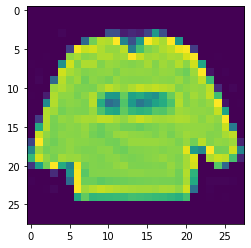

In [19]:
plt.imshow(X_train[0].reshape(28, 28))

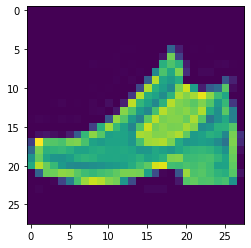

In [20]:
plt.imshow(X_train[1].reshape(28, 28))

In [21]:
BATCH_SIZE = 32

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)
torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)

train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

В качестве базовой модели, с которой будем сравнивать, возьмем простую нейронную сеть с тремя полносвязными слоями.

In [22]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return X

mlp = MLP()
print(mlp)

MLP(
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)


In [23]:
def fit(model, train_loader, epoch_number=5):
    optimizer = torch.optim.Adam(model.parameters())
    error = nn.CrossEntropyLoss()
    model.train()
    
    for epoch in range(epoch_number):
        correct = 0
        
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            if batch_idx % 200 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))

In [24]:
def evaluate(model):
    correct = 0 
    for test_imgs, test_labels in test_loader:
        test_imgs = Variable(test_imgs).float()
        
        output = model(test_imgs)
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()
    print("Test accuracy:{:.3f}% ".format( float(correct) / (len(test_loader)*BATCH_SIZE)))

Обучим модель и посмотрим, какое качество она выдает на наших данных.

In [25]:
torch.manual_seed(SEED)
fit(mlp, train_loader)

Epoch : 0 [0/60000 (0%)]	Loss: 17.452322	 Accuracy:3.125%
Epoch : 0 [6400/60000 (11%)]	Loss: 0.776435	 Accuracy:69.030%
Epoch : 0 [12800/60000 (21%)]	Loss: 0.852823	 Accuracy:73.566%
Epoch : 0 [19200/60000 (32%)]	Loss: 0.474309	 Accuracy:75.109%
Epoch : 0 [25600/60000 (43%)]	Loss: 0.257116	 Accuracy:76.537%
Epoch : 0 [32000/60000 (53%)]	Loss: 0.651054	 Accuracy:77.316%
Epoch : 0 [38400/60000 (64%)]	Loss: 0.526560	 Accuracy:78.029%
Epoch : 0 [44800/60000 (75%)]	Loss: 0.484273	 Accuracy:78.689%
Epoch : 0 [51200/60000 (85%)]	Loss: 0.247172	 Accuracy:79.109%
Epoch : 0 [57600/60000 (96%)]	Loss: 0.271017	 Accuracy:79.508%
Epoch : 1 [0/60000 (0%)]	Loss: 0.501332	 Accuracy:84.375%
Epoch : 1 [6400/60000 (11%)]	Loss: 0.580329	 Accuracy:83.458%
Epoch : 1 [12800/60000 (21%)]	Loss: 0.802431	 Accuracy:83.728%
Epoch : 1 [19200/60000 (32%)]	Loss: 0.240229	 Accuracy:83.689%
Epoch : 1 [25600/60000 (43%)]	Loss: 0.274157	 Accuracy:83.926%
Epoch : 1 [32000/60000 (53%)]	Loss: 0.478150	 Accuracy:84.000%
Epoc

In [26]:
evaluate(mlp)

Test accuracy:0.862% 


In [27]:
import pandas as pd

df = pd.read_csv('data/fashion-mnist_test.csv')

In [28]:
X_test = df.drop(['label'],axis=1).values
y_test = df['label'].values

In [29]:
r_data = [X_test[0].tolist()]

In [30]:
input_data = torch.tensor(r_data)

In [42]:
in2 = Variable(torch.from_numpy(np.array(r_data)).type(torch.LongTensor).float())

In [44]:
softmax = nn.Softmax(dim=1)

In [45]:
out = mlp(in2)

In [47]:
pred_probs = softmax(out)

In [57]:
index = torch.argmax(pred_probs[0]).item()

In [60]:
pred_probs[0][index].item()

0.624250590801239

In [61]:
pred_probs

tensor([[3.7410e-01, 1.0486e-07, 1.7212e-04, 1.4004e-03, 2.4034e-05, 1.4562e-08,
         6.2425e-01, 2.7763e-10, 5.1771e-05, 9.1662e-09]],
       grad_fn=<SoftmaxBackward>)

In [39]:
mlp(Variable(torch_X_test).float())

tensor([[  4.8889, -10.1986,  -2.7952,  ..., -16.1326,  -3.9966, -12.6357],
        [ -4.5517,  23.1163,  -6.3998,  ..., -34.8441, -14.2545, -31.1900],
        [  3.2077,  -0.6260,   4.9138,  ..., -15.2540,   1.1353, -15.1236],
        ...,
        [ 13.8483, -18.7048, -13.2403,  ...,  -3.9779,  40.8589,  -2.1101],
        [  5.4096,  -4.1935,  -0.1891,  ..., -11.3076,   7.3288, -12.9073],
        [  0.1158,   0.8623,   1.8577,  ...,  -5.5888,  -1.1536,  -6.9834]],
       grad_fn=<AddmmBackward>)

In [35]:
torch_X_train

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [36]:
in2

tensor([[  0,   0,   0,   0,   0,   0,   0,   9,   8,   0,   0,  34,  29,   7,
           0,  11,  24,   0,   0,   3,   3,   1,   0,   1,   1,   0,   0,   0,
           0,   0,   4,   0,   0,   1,   0,   0,   0,   0,   0,  44,  88,  99,
         122, 123,  80,   0,   0,   0,   0,   1,   1,   1,   0,   0,   0,   0,
           0,   0,   1,   2,   0,   0,   0,   3,  46, 174, 249,  67,   0,  94,
         210,  61,  14, 212, 157,  37,   0,   0,   0,   0,   1,   0,   0,   0,
           0,   0,   2,   2,   0,  23, 168, 206, 242, 239, 238, 214, 125,  61,
         113,  74, 133, 236, 238, 236, 203, 184,  20,   0,   1,   0,   0,   0,
           0,   0,   1,   0,   0, 175, 245, 223, 207, 205, 206, 216, 255, 237,
         251, 232, 223, 212, 200, 205, 216, 249, 173,   0,   0,   2,   0,   0,
           0,   0,   7,   0,  53, 225, 201, 197, 200, 201, 206, 199, 197, 185,
         194, 204, 232, 226, 249, 219, 194, 205, 229,  33,   0,   1,   0,   0,
           0,   0,   1,   0, 133, 223, 208, 192, 195

In [41]:
mlp(in2)

RuntimeError: Expected object of scalar type Float but got scalar type Long for argument #2 'mat1' in call to _th_addmm

Посмотрим на размер модели

In [40]:
def calc_weights(model):
    result = 0
    for layer in model.children():
        result += len(layer.weight.reshape(-1))
    return result

In [41]:
calc_weights(mlp)

222000

Достаточно большое количество параметров. 

Попробуем сделать модель сильно меньше и улучить ее, дистилировав в нее знания из большой модели.

В качестве такой модели возьмем сеть с одним скрытым слоем на 16 нейронов: 784 - 16 - 10

In [42]:
class StudentMLP(nn.Module):
    def __init__(self):
        super(StudentMLP, self).__init__()
        self.linear1 = nn.Linear(784,16)
        self.linear2 = nn.Linear(16,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = self.linear2(X)
        return X

In [43]:
smlp_simple = StudentMLP()

In [44]:
calc_weights(smlp_simple)

12704

12 000 - это примерно 5% от изначальной сети. Попробуем просто обучить ее на данных и посмотрим, какое качество вообще она может выдать самостоятельно.

In [45]:
torch.manual_seed(SEED)
fit(smlp_simple, train_loader)

Epoch : 0 [0/60000 (0%)]	Loss: 50.468872	 Accuracy:3.125%
Epoch : 0 [6400/60000 (11%)]	Loss: 1.258342	 Accuracy:37.749%
Epoch : 0 [12800/60000 (21%)]	Loss: 1.803313	 Accuracy:46.875%
Epoch : 0 [19200/60000 (32%)]	Loss: 1.222115	 Accuracy:49.792%
Epoch : 0 [25600/60000 (43%)]	Loss: 1.066455	 Accuracy:50.534%
Epoch : 0 [32000/60000 (53%)]	Loss: 1.179734	 Accuracy:51.074%
Epoch : 0 [38400/60000 (64%)]	Loss: 1.131818	 Accuracy:51.837%
Epoch : 0 [44800/60000 (75%)]	Loss: 0.964317	 Accuracy:52.621%
Epoch : 0 [51200/60000 (85%)]	Loss: 0.881685	 Accuracy:53.279%
Epoch : 0 [57600/60000 (96%)]	Loss: 0.697759	 Accuracy:53.824%
Epoch : 1 [0/60000 (0%)]	Loss: 1.039469	 Accuracy:50.000%
Epoch : 1 [6400/60000 (11%)]	Loss: 0.804221	 Accuracy:59.904%
Epoch : 1 [12800/60000 (21%)]	Loss: 1.402066	 Accuracy:60.263%
Epoch : 1 [19200/60000 (32%)]	Loss: 0.846651	 Accuracy:60.472%
Epoch : 1 [25600/60000 (43%)]	Loss: 0.866411	 Accuracy:60.725%
Epoch : 1 [32000/60000 (53%)]	Loss: 0.843927	 Accuracy:60.845%
Epoc

In [46]:
evaluate(smlp_simple)

Test accuracy:0.636% 


Видно, что модель слабее и качество упало примерно на 20%.

Попробуем задействовать большую модель для улучшения качества. Для этого сконструируем более сложную функцию ошибки. 

Одно из слагаемых как и раньше - это просто кросс-энтропия для данных их обучающей выборки.

Второе слагаемое - это кросс-энтропия между распределением вероятностей ответов, которое мы получили от большой модели и распределением веротяностей ответов, которое предсказывает наша модель. Мы также дополнительно сглаживаем эти распределения с помощью параметра "температуры" T. Это нужно, чтобы вытянуть из большой модели больше информации про данные.

Складываем взвешенно эти два слагаемых с весами альфа и 1-альфа и для такой функции ошибки уже учим нашу модель как обычно.

In [47]:
def distill(teacher_model, student_model, train_loader, epoch_number=5, alpha=0.5, temperature=2):
    def error_and_output(var_X_batch, var_y_batch): # Задаем нашу особую функцию ошибки
        # Дивергенция Кульбака-Лейблера нужна, чтобы подсчитать кросс-энтропию между двумя распределениями
        # А именно между распределениями ответов модели-учителя и модели-ученика
        kldloss = nn.KLDivLoss()  
        # Для подсчета ошибки на данных воспользуемся уже готовой функцией для кросс-энтропии
        celoss = nn.CrossEntropyLoss()
        
        # Считаем выходы из сети-учителя
        teacher_logits = teacher_model(var_X_batch)
        # И выходы из сети-ученика
        student_logits = student_model(var_X_batch)
        
        # Рассчитываем распределение вероятностей ответов с помощью softmax с параметром T для сети-ученика
        soft_predictions = F.log_softmax( student_logits / temperature, dim=1 )
        # И для сети-учителя
        soft_labels = F.softmax( teacher_logits / temperature, dim=1 )
        # Считаем ошибку дистиляции - кросс-энтропию между распределениями ответов моделей
        distillation_loss = kldloss(soft_predictions, soft_labels)
        
        # Считаем ошибку на данных - кросс-энтропию между распределением ответов сети-ученика и правильным ответом
        student_loss = celoss(student_logits, var_y_batch)
        
        # Складываем с весами
        return distillation_loss * alpha + student_loss * (1 - alpha), student_logits
    
    optimizer = torch.optim.Adam(student_model.parameters())
    student_model.train()
    
    # Далее обучение проходит как обычно
    for epoch in range(epoch_number):
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            loss, output = error_and_output(var_X_batch, var_y_batch)
            loss.backward()
            optimizer.step()

            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            if batch_idx % 200 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))

Попробуем обучить таким образом модель с T = 10

In [25]:
torch.manual_seed(SEED)
smlp = StudentMLP()
distill(mlp, smlp, train_loader, temperature=10.0)

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch : 0 [0/60000 (0%)]	Loss: 18.051939	 Accuracy:9.375%
Epoch : 0 [6400/60000 (11%)]	Loss: 1.031293	 Accuracy:23.057%
Epoch : 0 [12800/60000 (21%)]	Loss: 0.922963	 Accuracy:29.832%
Epoch : 0 [19200/60000 (32%)]	Loss: 0.806358	 Accuracy:32.888%
Epoch : 0 [25600/60000 (43%)]	Loss: 0.655243	 Accuracy:34.765%
Epoch : 0 [32000/60000 (53%)]	Loss: 0.776560	 Accuracy:36.217%
Epoch : 0 [38400/60000 (64%)]	Loss: 0.883896	 Accuracy:37.510%
Epoch : 0 [44800/60000 (75%)]	Loss: 0.630573	 Accuracy:38.412%
Epoch : 0 [51200/60000 (85%)]	Loss: 0.589253	 Accuracy:39.659%
Epoch : 0 [57600/60000 (96%)]	Loss: 0.580639	 Accuracy:41.097%
Epoch : 1 [0/60000 (0%)]	Loss: 0.593468	 Accuracy:65.625%
Epoch : 1 [6400/60000 (11%)]	Loss: 0.730674	 Accuracy:55.348%
Epoch : 1 [12800/60000 (21%)]	Loss: 0.721611	 Accuracy:56.055%
Epoch : 1 [19200/60000 (32%)]	Loss: 0.451817	 Accuracy:56.453%
Epoch : 1 [25600/60000 (43%)]	Loss: 0.536171	 Accuracy:56.582%
Epoch : 1 [32000/60000 (53%)]	Loss: 0.541939	 Accuracy:56.721%
Epoc

In [26]:
evaluate(smlp)

Test accuracy:0.766% 


Качество модели увеличилось почти на 15%! Хотя до большой сети все еще немного не дотягивает. 

Перебирая параметры можно пытаться получить качество еще лучше.

In [27]:
torch.manual_seed(SEED)
smlp = StudentMLP()
distill(mlp, smlp, train_loader, temperature=5.0)

Epoch : 0 [0/60000 (0%)]	Loss: 18.237700	 Accuracy:9.375%
Epoch : 0 [6400/60000 (11%)]	Loss: 0.973386	 Accuracy:18.517%
Epoch : 0 [12800/60000 (21%)]	Loss: 1.083604	 Accuracy:21.758%
Epoch : 0 [19200/60000 (32%)]	Loss: 0.913332	 Accuracy:26.711%
Epoch : 0 [25600/60000 (43%)]	Loss: 0.679522	 Accuracy:30.271%
Epoch : 0 [32000/60000 (53%)]	Loss: 0.789727	 Accuracy:32.455%
Epoch : 0 [38400/60000 (64%)]	Loss: 1.107024	 Accuracy:34.825%
Epoch : 0 [44800/60000 (75%)]	Loss: 0.658259	 Accuracy:36.708%
Epoch : 0 [51200/60000 (85%)]	Loss: 0.556574	 Accuracy:38.349%
Epoch : 0 [57600/60000 (96%)]	Loss: 0.552491	 Accuracy:39.764%
Epoch : 1 [0/60000 (0%)]	Loss: 0.653471	 Accuracy:59.375%
Epoch : 1 [6400/60000 (11%)]	Loss: 0.728044	 Accuracy:52.938%
Epoch : 1 [12800/60000 (21%)]	Loss: 0.763170	 Accuracy:54.317%
Epoch : 1 [19200/60000 (32%)]	Loss: 0.482753	 Accuracy:54.591%
Epoch : 1 [25600/60000 (43%)]	Loss: 0.554149	 Accuracy:55.126%
Epoch : 1 [32000/60000 (53%)]	Loss: 0.555983	 Accuracy:55.376%
Epoc

In [28]:
evaluate(smlp)

Test accuracy:0.765% 


In [29]:
torch.manual_seed(SEED)
smlp = StudentMLP()
distill(mlp, smlp, train_loader, temperature=2.0)

Epoch : 0 [0/60000 (0%)]	Loss: 18.807398	 Accuracy:9.375%
Epoch : 0 [6400/60000 (11%)]	Loss: 1.029747	 Accuracy:21.393%
Epoch : 0 [12800/60000 (21%)]	Loss: 1.008816	 Accuracy:24.096%
Epoch : 0 [19200/60000 (32%)]	Loss: 0.854174	 Accuracy:26.076%
Epoch : 0 [25600/60000 (43%)]	Loss: 0.772763	 Accuracy:28.043%
Epoch : 0 [32000/60000 (53%)]	Loss: 0.914996	 Accuracy:29.558%
Epoch : 0 [38400/60000 (64%)]	Loss: 1.309228	 Accuracy:31.419%
Epoch : 0 [44800/60000 (75%)]	Loss: 0.692897	 Accuracy:32.698%
Epoch : 0 [51200/60000 (85%)]	Loss: 0.718221	 Accuracy:33.930%
Epoch : 0 [57600/60000 (96%)]	Loss: 0.631064	 Accuracy:34.934%
Epoch : 1 [0/60000 (0%)]	Loss: 0.741131	 Accuracy:53.125%
Epoch : 1 [6400/60000 (11%)]	Loss: 0.753406	 Accuracy:45.989%
Epoch : 1 [12800/60000 (21%)]	Loss: 0.802172	 Accuracy:46.922%
Epoch : 1 [19200/60000 (32%)]	Loss: 0.566999	 Accuracy:48.284%
Epoch : 1 [25600/60000 (43%)]	Loss: 0.599084	 Accuracy:49.224%
Epoch : 1 [32000/60000 (53%)]	Loss: 0.639231	 Accuracy:49.348%
Epoc

In [30]:
evaluate(smlp)

Test accuracy:0.718% 


In [31]:
torch.manual_seed(SEED)
smlp = StudentMLP()
distill(mlp, smlp, train_loader, temperature=1.5)

Epoch : 0 [0/60000 (0%)]	Loss: 19.113735	 Accuracy:9.375%
Epoch : 0 [6400/60000 (11%)]	Loss: 1.088714	 Accuracy:18.626%
Epoch : 0 [12800/60000 (21%)]	Loss: 1.027413	 Accuracy:20.940%
Epoch : 0 [19200/60000 (32%)]	Loss: 0.979876	 Accuracy:22.062%
Epoch : 0 [25600/60000 (43%)]	Loss: 0.832493	 Accuracy:23.763%
Epoch : 0 [32000/60000 (53%)]	Loss: 0.939549	 Accuracy:24.632%
Epoch : 0 [38400/60000 (64%)]	Loss: 1.208642	 Accuracy:26.517%
Epoch : 0 [44800/60000 (75%)]	Loss: 0.693540	 Accuracy:27.955%
Epoch : 0 [51200/60000 (85%)]	Loss: 0.701821	 Accuracy:29.780%
Epoch : 0 [57600/60000 (96%)]	Loss: 0.634311	 Accuracy:31.203%
Epoch : 1 [0/60000 (0%)]	Loss: 0.766185	 Accuracy:34.375%
Epoch : 1 [6400/60000 (11%)]	Loss: 0.766767	 Accuracy:43.766%
Epoch : 1 [12800/60000 (21%)]	Loss: 1.017757	 Accuracy:43.875%
Epoch : 1 [19200/60000 (32%)]	Loss: 0.648921	 Accuracy:43.734%
Epoch : 1 [25600/60000 (43%)]	Loss: 0.623931	 Accuracy:44.245%
Epoch : 1 [32000/60000 (53%)]	Loss: 0.683474	 Accuracy:44.150%
Epoc

In [32]:
evaluate(smlp)

Test accuracy:0.576% 


Также можем попробовать изменить веса для слагаемых в ошибке.
Возьмем модель с T = 5 и попробуем изменением весов ее улучшить

In [33]:
torch.manual_seed(SEED)
smlp = StudentMLP()
distill(mlp, smlp, train_loader, temperature=5.0, alpha=0.2)

Epoch : 0 [0/60000 (0%)]	Loss: 28.813070	 Accuracy:9.375%
Epoch : 0 [6400/60000 (11%)]	Loss: 1.663249	 Accuracy:21.797%
Epoch : 0 [12800/60000 (21%)]	Loss: 1.506650	 Accuracy:26.675%
Epoch : 0 [19200/60000 (32%)]	Loss: 1.278597	 Accuracy:30.891%
Epoch : 0 [25600/60000 (43%)]	Loss: 1.045085	 Accuracy:33.630%
Epoch : 0 [32000/60000 (53%)]	Loss: 1.188174	 Accuracy:35.589%
Epoch : 0 [38400/60000 (64%)]	Loss: 2.018281	 Accuracy:37.940%
Epoch : 0 [44800/60000 (75%)]	Loss: 1.068962	 Accuracy:39.425%
Epoch : 0 [51200/60000 (85%)]	Loss: 0.856626	 Accuracy:40.748%
Epoch : 0 [57600/60000 (96%)]	Loss: 0.808763	 Accuracy:41.850%
Epoch : 1 [0/60000 (0%)]	Loss: 0.870942	 Accuracy:65.625%
Epoch : 1 [6400/60000 (11%)]	Loss: 1.193262	 Accuracy:52.752%
Epoch : 1 [12800/60000 (21%)]	Loss: 1.201379	 Accuracy:53.647%
Epoch : 1 [19200/60000 (32%)]	Loss: 0.740859	 Accuracy:54.435%
Epoch : 1 [25600/60000 (43%)]	Loss: 0.811783	 Accuracy:54.877%
Epoch : 1 [32000/60000 (53%)]	Loss: 0.841314	 Accuracy:55.176%
Epoc

In [34]:
evaluate(smlp)

Test accuracy:0.710% 


In [35]:
torch.manual_seed(SEED)
smlp = StudentMLP()
distill(mlp, smlp, train_loader, temperature=5, alpha=0.9)

Epoch : 0 [0/60000 (0%)]	Loss: 4.137208	 Accuracy:9.375%
Epoch : 0 [6400/60000 (11%)]	Loss: 0.231639	 Accuracy:19.885%
Epoch : 0 [12800/60000 (21%)]	Loss: 0.226190	 Accuracy:25.553%
Epoch : 0 [19200/60000 (32%)]	Loss: 0.209725	 Accuracy:28.063%
Epoch : 0 [25600/60000 (43%)]	Loss: 0.185707	 Accuracy:31.164%
Epoch : 0 [32000/60000 (53%)]	Loss: 0.201776	 Accuracy:33.348%
Epoch : 0 [38400/60000 (64%)]	Loss: 0.190182	 Accuracy:35.681%
Epoch : 0 [44800/60000 (75%)]	Loss: 0.149032	 Accuracy:37.734%
Epoch : 0 [51200/60000 (85%)]	Loss: 0.126203	 Accuracy:39.616%
Epoch : 0 [57600/60000 (96%)]	Loss: 0.117845	 Accuracy:41.654%
Epoch : 1 [0/60000 (0%)]	Loss: 0.118269	 Accuracy:68.750%
Epoch : 1 [6400/60000 (11%)]	Loss: 0.145554	 Accuracy:60.759%
Epoch : 1 [12800/60000 (21%)]	Loss: 0.192144	 Accuracy:62.718%
Epoch : 1 [19200/60000 (32%)]	Loss: 0.080345	 Accuracy:63.472%
Epoch : 1 [25600/60000 (43%)]	Loss: 0.095022	 Accuracy:63.955%
Epoch : 1 [32000/60000 (53%)]	Loss: 0.093581	 Accuracy:64.351%
Epoch

In [36]:
evaluate(smlp)

Test accuracy:0.786% 


Видно, что обучение чувствительно к тому, на что должна смотреть модель - на правильный ответ или на "интуицию" большой модели.

В итоге, у нас получилось обучить модель в 20 раз меньше оригинальной при этом не слишком сильно потерять в качестве.

## Квантизация нейронных сетей

В этой лабораторной попробуем уменьшить размер нейронной сети, а также усторить ее работу, заменяя float на int внутри сети.

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import copy

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from torch.quantization import QuantStub, DeQuantStub

In [60]:
SEED=9876
torch.manual_seed(SEED)

Вновь пробуем обучить сеть из трех полносвязных слоев на fashion mnist.

In [61]:
train_csv = pd.read_csv("fashion-mnist_train.csv")
test_csv = pd.read_csv("fashion-mnist_test.csv")

In [62]:
device = torch.device("cpu")

In [63]:
train_csv.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
y_train = train_csv['label'].values
X_train = train_csv.drop(['label'],axis=1).values

y_test = test_csv['label'].values
X_test = test_csv.drop(['label'],axis=1).values

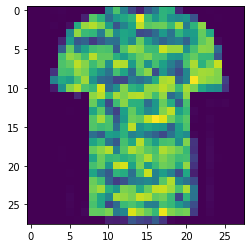

In [65]:
plt.imshow(X_train[3].reshape(28, 28))

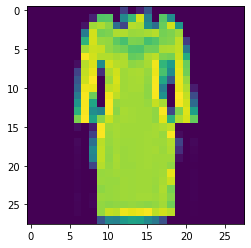

In [66]:
plt.imshow(X_train[4].reshape(28, 28))

In [67]:
BATCH_SIZE = 32

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)
torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)

train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

In [68]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return X

mlp = MLP()
print(mlp)

MLP(
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)


In [69]:
def fit(model, train_loader, epoch_number=5):
    optimizer = torch.optim.Adam(model.parameters())
    error = nn.CrossEntropyLoss()
    model.train()
    
    for epoch in range(epoch_number):
        correct = 0
        
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            if batch_idx % 200 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))

In [70]:
def evaluate(model, loader=test_loader):
    correct = 0 
    for test_imgs, test_labels in loader:
        test_imgs = Variable(test_imgs).float()
        
        output = model(test_imgs)
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()
    print("Test accuracy:{:.3f}% ".format( float(correct) / (len(loader)*BATCH_SIZE)))

In [71]:
torch.manual_seed(SEED)
fit(mlp, train_loader)

Epoch : 0 [0/60000 (0%)]	Loss: 17.452320	 Accuracy:3.125%
Epoch : 0 [6400/60000 (11%)]	Loss: 0.777609	 Accuracy:69.045%
Epoch : 0 [12800/60000 (21%)]	Loss: 0.971888	 Accuracy:72.958%
Epoch : 0 [19200/60000 (32%)]	Loss: 0.423758	 Accuracy:75.078%
Epoch : 0 [25600/60000 (43%)]	Loss: 0.300038	 Accuracy:76.381%
Epoch : 0 [32000/60000 (53%)]	Loss: 0.521944	 Accuracy:77.301%
Epoch : 0 [38400/60000 (64%)]	Loss: 0.464210	 Accuracy:78.047%
Epoch : 0 [44800/60000 (75%)]	Loss: 0.300150	 Accuracy:78.589%
Epoch : 0 [51200/60000 (85%)]	Loss: 0.275364	 Accuracy:79.042%
Epoch : 0 [57600/60000 (96%)]	Loss: 0.241909	 Accuracy:79.402%
Epoch : 1 [0/60000 (0%)]	Loss: 0.488709	 Accuracy:84.375%
Epoch : 1 [6400/60000 (11%)]	Loss: 0.477927	 Accuracy:83.116%
Epoch : 1 [12800/60000 (21%)]	Loss: 0.779009	 Accuracy:83.588%
Epoch : 1 [19200/60000 (32%)]	Loss: 0.315745	 Accuracy:83.709%
Epoch : 1 [25600/60000 (43%)]	Loss: 0.278790	 Accuracy:83.813%
Epoch : 1 [32000/60000 (53%)]	Loss: 0.567111	 Accuracy:83.719%
Epoc

In [72]:
evaluate(mlp)

Test accuracy:0.854% 


Уменьшать количество самих весов в этот раз мы не будем, поэтому в качестве размера нейронной сети будет использовать буквально количество памяти, которая она занимает.

In [73]:
def calc_size(model):
    torch.save(model.state_dict(), "/tmp/model.p")
    size=os.path.getsize("/tmp/model.p")
    os.remove('/tmp/model.p')
    return "{:.3f} KB".format(size / 1024)

In [74]:
calc_size(mlp)

'870.729 KB'

Полученная сеть весит почти мегабайт.

Посмотрим на веса, которые используются внутри нашей сети

In [75]:
mlp.linear1.weight

Parameter containing:
tensor([[ 0.0328,  0.0293,  0.0301,  ..., -0.0090,  0.0263,  0.0303],
        [-0.0152,  0.0219, -0.0283,  ...,  0.0117,  0.0584,  0.0334],
        [-0.0097, -0.0417,  0.0250,  ..., -0.0420,  0.0145,  0.0303],
        ...,
        [-0.0203, -0.0009,  0.0205,  ...,  0.0123,  0.0195,  0.0143],
        [-0.0187, -0.0666,  0.0168,  ...,  0.0614,  0.0164, -0.0347],
        [-0.0037,  0.0156,  0.0021,  ..., -0.0133, -0.0365,  0.0120]],
       requires_grad=True)

In [76]:
mlp

MLP(
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)

Посчитаем дополнительно, за сколько в среднем она делает предсказания. Для замеров по времени будем использовать один поток, чтобы все сети были в одинаковых условиях.

In [77]:
from contextlib import contextmanager

@contextmanager
def single_thread():  
    num = torch.get_num_threads()
    torch.set_num_threads(1)
    yield
    torch.set_num_threads(num)

In [78]:
%%timeit -r10

with single_thread():
    evaluate(mlp, train_loader)

Test accuracy:0.864% 
Test accuracy:0.864% 
Test accuracy:0.864% 
Test accuracy:0.864% 
Test accuracy:0.864% 
Test accuracy:0.864% 
Test accuracy:0.864% 
Test accuracy:0.864% 
Test accuracy:0.864% 
Test accuracy:0.864% 
Test accuracy:0.864% 
1.43 s ± 9.38 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


### Динамическая квантизация

Динамическая квантизация - пожалуй самый простой способ квантизации. 

Все веса из float мы сразу переводим в int, а вот активации мы пересчитываем на лету во время работы сети. Для каждого примера в нейроне мы аккумулируем взвешенную сумму по-честному во float, подбираем для конкретного получившегося числа лучшие параметры квантизации, квантуем и отправляем дальше по сети.

Таким образом, из-за этих автоматических квантований во время работы сети сеть все еще может работать медленно.

Попробуем применить динамическую квантизацию к нашей модели.

In [79]:
qd_mlp = torch.quantization.quantize_dynamic(
    mlp, {nn.Linear}, dtype=torch.qint8
)

In [80]:
qd_mlp

MLP(
  (linear1): DynamicQuantizedLinear(in_features=784, out_features=250, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (linear2): DynamicQuantizedLinear(in_features=250, out_features=100, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (linear3): DynamicQuantizedLinear(in_features=100, out_features=10, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)

In [81]:
calc_size(qd_mlp)

'222.351 KB'

Видно, что получилось уменьшить размер сети почти в 4 раза. Посмотрим, что случилось с качеством полученной модели.

In [82]:
evaluate(qd_mlp)

Test accuracy:0.863% 


Качество осталось в точности таким же.

Заглянем в то, какие теперь веса используются внутри.

In [83]:
qd_mlp.linear1.weight().int_repr()

tensor([[  7,   6,   6,  ...,  -2,   5,   6],
        [ -3,   5,  -6,  ...,   2,  12,   7],
        [ -2,  -9,   5,  ...,  -9,   3,   6],
        ...,
        [ -4,   0,   4,  ...,   3,   4,   3],
        [ -4, -14,   3,  ...,  13,   3,  -7],
        [ -1,   3,   0,  ...,  -3,  -8,   2]], dtype=torch.int8)

In [84]:
mlp.linear1.weight

Parameter containing:
tensor([[ 0.0328,  0.0293,  0.0301,  ..., -0.0090,  0.0263,  0.0303],
        [-0.0152,  0.0219, -0.0283,  ...,  0.0117,  0.0584,  0.0334],
        [-0.0097, -0.0417,  0.0250,  ..., -0.0420,  0.0145,  0.0303],
        ...,
        [-0.0203, -0.0009,  0.0205,  ...,  0.0123,  0.0195,  0.0143],
        [-0.0187, -0.0666,  0.0168,  ...,  0.0614,  0.0164, -0.0347],
        [-0.0037,  0.0156,  0.0021,  ..., -0.0133, -0.0365,  0.0120]],
       requires_grad=True)

Помотрим, насколько быстро получается делать предсказания квантизированной моделью.

In [85]:
%%timeit -r10

with single_thread():
    evaluate(qd_mlp, train_loader)

Test accuracy:0.871% 
Test accuracy:0.871% 
Test accuracy:0.871% 
Test accuracy:0.871% 
Test accuracy:0.871% 
Test accuracy:0.871% 
Test accuracy:0.871% 
Test accuracy:0.871% 
Test accuracy:0.871% 
Test accuracy:0.871% 
Test accuracy:0.871% 
1.25 s ± 13.3 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


На моем компьютере получился прирост примерно в 10-15%. Таким образом динамическая квантизация - достаточно простой прием, который не дает большого проигрышал по качеству, при этом уменьшает размер сети и ускоряет предсказания.

Однако это не единственный подход для квантования. 

### Статическая квантизация

Статическая квантизация позволяет сразу все операции перевести в int, без необходимости дополнительно что-то расчитывать в процессе предсказания.

Для того, чтобы при этом качество не сильно пострадало, параметры квантования для разных слоем настраиваются по обучающей выборке.

Таким образом для того, чтобы статически квантизировать сеть, необходимо вначале подключить к ней модуль подсчета параметров (Observer), который будет для каждого слоя расчитывать необходимые параметры квантования по обучающей выборке. После этого один раз необходимо всю выборку прогнать через сеть, чтобы эти модули смогли подсчитать нужные параметры. После чего можно фиксировать полученные параметры и итоговую квантизированную сеть.

In [86]:
class QuantizedMLP(nn.Module):
    def __init__(self):
        super(QuantizedMLP, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
        # Так как теперь квантизация не происходит динамически, необходимо дополнительно 
        # руками квантовать входные данные и деквантовать ответ
        self.quant = QuantStub()
        self.dequant = DeQuantStub()
    
    def forward(self,X):
        # Квантуем входные данные
        X = self.quant(X)
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        # Деквантуем ответ
        X = self.dequant(X)
        return X

In [87]:
ptq_mlp = QuantizedMLP()

In [88]:
torch.manual_seed(SEED)
fit(ptq_mlp, train_loader)

Epoch : 0 [0/60000 (0%)]	Loss: 11.684026	 Accuracy:18.750%
Epoch : 0 [6400/60000 (11%)]	Loss: 0.835062	 Accuracy:69.450%
Epoch : 0 [12800/60000 (21%)]	Loss: 0.927683	 Accuracy:74.158%
Epoch : 0 [19200/60000 (32%)]	Loss: 0.419413	 Accuracy:75.499%
Epoch : 0 [25600/60000 (43%)]	Loss: 0.377385	 Accuracy:76.701%
Epoch : 0 [32000/60000 (53%)]	Loss: 0.569878	 Accuracy:77.644%
Epoch : 0 [38400/60000 (64%)]	Loss: 0.492238	 Accuracy:78.427%
Epoch : 0 [44800/60000 (75%)]	Loss: 0.430269	 Accuracy:79.044%
Epoch : 0 [51200/60000 (85%)]	Loss: 0.268351	 Accuracy:79.493%
Epoch : 0 [57600/60000 (96%)]	Loss: 0.265719	 Accuracy:79.846%
Epoch : 1 [0/60000 (0%)]	Loss: 0.743126	 Accuracy:75.000%
Epoch : 1 [6400/60000 (11%)]	Loss: 0.498857	 Accuracy:84.126%
Epoch : 1 [12800/60000 (21%)]	Loss: 0.798827	 Accuracy:84.305%
Epoch : 1 [19200/60000 (32%)]	Loss: 0.250168	 Accuracy:84.354%
Epoch : 1 [25600/60000 (43%)]	Loss: 0.277832	 Accuracy:84.508%
Epoch : 1 [32000/60000 (53%)]	Loss: 0.541766	 Accuracy:84.547%
Epo

In [89]:
evaluate(ptq_mlp)

Test accuracy:0.862% 


In [90]:
# Для моделей мы также можем указать конфиг квантования,
# где в частности может указать библиотеку для работы с квантованными значениями

ptq_mlp.qconfig = torch.quantization.get_default_qconfig('fbgemm')

In [91]:
# Устанавливаем модули подсчета параметров квантования. По умолчанию исползуется HistogramObserver, то есть
# модуль, который рассчтывает параметры на основе гистрограммы распределения значнеий для конкретного слоя
torch.quantization.prepare(ptq_mlp, inplace=True)

/Users/AlexHome/vms/lsml-internal/venv/lib/python3.9/site-packages/torch/quantization/observer.py:119: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


QuantizedMLP(
  (linear1): Linear(
    in_features=784, out_features=250, bias=True
    (activation_post_process): HistogramObserver()
  )
  (linear2): Linear(
    in_features=250, out_features=100, bias=True
    (activation_post_process): HistogramObserver()
  )
  (linear3): Linear(
    in_features=100, out_features=10, bias=True
    (activation_post_process): HistogramObserver()
  )
  (quant): QuantStub(
    (activation_post_process): HistogramObserver()
  )
  (dequant): DeQuantStub()
)

In [92]:
# Прогоняем всю обучающую выборку через сеть. Для этого просто считаем качество на данных обучающей выборки
# Само значение нам не интересно, нам важно, чтобы посчитались параметры
evaluate(ptq_mlp, train_loader)

Test accuracy:0.870% 


In [94]:
# Фиксируем полученные веса и параметры квантизации
torch.quantization.convert(ptq_mlp, inplace=True)

QuantizedMLP(
  (linear1): QuantizedLinear(in_features=784, out_features=250, scale=46.39590072631836, zero_point=91, qscheme=torch.per_channel_affine)
  (linear2): QuantizedLinear(in_features=250, out_features=100, scale=9.414811134338379, zero_point=85, qscheme=torch.per_channel_affine)
  (linear3): QuantizedLinear(in_features=100, out_features=10, scale=3.005615472793579, zero_point=93, qscheme=torch.per_channel_affine)
  (quant): Quantize(scale=tensor([2.0069]), zero_point=tensor([0]), dtype=torch.quint8)
  (dequant): DeQuantize()
)

Можно видеть, какие именно параметры (а именно scale и zero_point) подсчитались для каждого слоя.

In [95]:
calc_size(ptq_mlp)

'229.991 KB'

In [96]:
ptq_mlp.linear1.weight().int_repr()

tensor([[  -6,  -18,  -15,  ...,   51,  -16,  -30],
        [  -5,  -33,  -10,  ...,   19,  -31,  -25],
        [ -42,  -47,   61,  ...,   23,   68,   57],
        ...,
        [  35,   -8,  -10,  ...,  -51,   25,  -72],
        [ -39,   79,    8,  ...,   58, -102,  -29],
        [ -84,   66,   68,  ...,  -35,   67,   86]], dtype=torch.int8)

In [97]:
evaluate(ptq_mlp)

Test accuracy:0.813% 


Видно, что модель все еще хорошо сжалась, при этом качество немного упало. 

Посмотрим, что по скорости выполнения.

In [98]:
%%timeit -r10

with single_thread():
    evaluate(ptq_mlp, train_loader)

Test accuracy:0.822% 
Test accuracy:0.822% 
Test accuracy:0.822% 
Test accuracy:0.822% 
Test accuracy:0.822% 
Test accuracy:0.822% 
Test accuracy:0.822% 
Test accuracy:0.822% 
Test accuracy:0.822% 
Test accuracy:0.822% 
Test accuracy:0.822% 
1.31 s ± 33.1 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


Видно, что с текущей моделью статическая квантизация работает не так хорошо - качество немного просело, а значительного прироста по времени не наблюдается.

Вместо простых схем квантизации, когда уже обученная модель квантуется, есть и более продвинутые схемы.

### Квантизация в процессе обучения

Этот метод заключается в том, что квантование происходит на каждом шаге градиентного спуска. Теоретически это должно делать более аккуратными относительно квантованных параметров и тем самым получать качество лучше.

In [98]:
qa_mlp = QuantizedMLP()

In [99]:
def quantized_fit(model, train_loader, epoch_number=5):
    optimizer = torch.optim.Adam(model.parameters())
    
    # Ничем особенным процесс обучения не отличается
    # Добавляем конфигурацию, после чего подготавливаем модель для обучения с квантованием
    # Модель внутри себя автоматически будет обновлять веса с учетом квантования
    model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
    torch.quantization.prepare_qat(model, inplace=True)
    
    error = nn.CrossEntropyLoss()
    model.train()
    
    for epoch in range(epoch_number):
        correct = 0
        
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            if batch_idx % 200 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))

In [100]:
torch.manual_seed(SEED)
quantized_fit(qa_mlp, train_loader)

Epoch : 0 [0/60000 (0%)]	Loss: 19.953337	 Accuracy:3.125%
Epoch : 0 [6400/60000 (11%)]	Loss: 1.015618	 Accuracy:68.470%
Epoch : 0 [12800/60000 (21%)]	Loss: 1.126122	 Accuracy:72.919%
Epoch : 0 [19200/60000 (32%)]	Loss: 0.382234	 Accuracy:74.698%
Epoch : 0 [25600/60000 (43%)]	Loss: 0.263492	 Accuracy:75.964%
Epoch : 0 [32000/60000 (53%)]	Loss: 0.520338	 Accuracy:76.795%
Epoch : 0 [38400/60000 (64%)]	Loss: 0.406278	 Accuracy:77.542%
Epoch : 0 [44800/60000 (75%)]	Loss: 0.436573	 Accuracy:78.083%
Epoch : 0 [51200/60000 (85%)]	Loss: 0.301557	 Accuracy:78.609%
Epoch : 0 [57600/60000 (96%)]	Loss: 0.401963	 Accuracy:79.013%
Epoch : 1 [0/60000 (0%)]	Loss: 0.458184	 Accuracy:87.500%
Epoch : 1 [6400/60000 (11%)]	Loss: 0.491694	 Accuracy:83.411%
Epoch : 1 [12800/60000 (21%)]	Loss: 0.751592	 Accuracy:83.619%
Epoch : 1 [19200/60000 (32%)]	Loss: 0.368394	 Accuracy:83.663%
Epoch : 1 [25600/60000 (43%)]	Loss: 0.291238	 Accuracy:83.770%
Epoch : 1 [32000/60000 (53%)]	Loss: 0.506257	 Accuracy:83.694%
Epoc

Можно заметить, что обучение идет немного дольше чем обычно

In [106]:
# После обучения с квантованием, фиксируем квантованные веса и параметры
quantized_model = torch.quantization.convert(qa_mlp, inplace=False)
quantized_model

PostTrainedQuantizedMLP(
  (linear1): QuantizedLinear(in_features=784, out_features=250, scale=35.50273513793945, zero_point=88, qscheme=torch.per_channel_affine)
  (linear2): QuantizedLinear(in_features=250, out_features=100, scale=5.187557697296143, zero_point=71, qscheme=torch.per_channel_affine)
  (linear3): QuantizedLinear(in_features=100, out_features=10, scale=0.8892423510551453, zero_point=74, qscheme=torch.per_channel_affine)
  (quant): Quantize(scale=tensor([2.0079]), zero_point=tensor([0]), dtype=torch.quint8)
  (dequant): DeQuantize()
)

In [107]:
evaluate(quantized_model)

Test accuracy:0.865% 


На моем компьютере качество получилось даже чуть выше, чем у оригинальной модели

In [109]:
calc_size(quantized_model)

'229.746 KB'

In [110]:
quantized_model.linear1.weight().int_repr()

tensor([[  -9,   13,  -17,  ...,  -34,  -34,  -65],
        [   9,    4,  -45,  ...,  -13,  -24,   65],
        [ -15,  -88,   29,  ...,  -72,   52,   53],
        ...,
        [  74,   50,  106,  ...,   75,  101,   31],
        [ -58,  -68,   57,  ..., -106,  -79,    8],
        [ -15,   58,  -44,  ...,  115,   37,  -63]], dtype=torch.int8)

In [112]:
%%timeit -r10

with single_thread():
    evaluate(quantized_model, train_loader)

Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
1.3 s ± 6.6 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


По итогу этих экспериментов можно сказать следующее - универсального метода квантизации не существует, в каждом конкретном случае нужно искать свой подход.

Однако все схемы показывают стабильное уменьшение размера модели при небольшом изменении метрики качества и ускорении расчета предсказаний.